In [1]:
%matplotlib inline

In [2]:
import os
import sys
import numpy


In [3]:
sys.path.insert(0,'/home/grotec/Codes/eucall-software/simex_platform/develop/lib/python3.4/wpg')

In [4]:
!ls /home/grotec/Codes/eucall-software/simex_platform/develop/lib/python3.4/wpg

beamline.py	     srwlib.pyc		    uti_plot_matplotlib.py
converters	     srwlpy.cpython-34m.so  uti_plot.py
generators.py	     srwl_uti_cryst.py	    vis_tools.py
glossary.py	     srwl_uti_src.py	    wavefront.py
__init__.py	     srwl_uti_und.py	    wavefront.pyc
__init__.pyc	     useful_code	    wpg_uti_exfl.py
optical_elements.py  uti_io.py		    wpg_uti_oe.py
__pycache__	     utils.py		    wpg_uti_wf.py
srwl_bl.py	     uti_math.py
srwlib.py	     uti_plot_com.py


In [5]:
from wpg import Wavefront, Beamline
from wpg.optical_elements import Drift
from wpg.optical_elements import Aperture
from wpg.optical_elements import Mirror_elliptical
from wpg.optical_elements import WF_dist
from wpg.optical_elements import calculateOPD
from wpg.optical_elements import Use_PP

#import SRW core functions
import srwl_bl
from wpg import srwlib
from wpg import srwlpy
from wpg.srwlib import srwl

##Gaussian beam generator
from wpg.generators import build_gauss_wavefront

from wpg.wpg_uti_exfl import calculate_theta_fwhm_cdr_s1
from wpg.wpg_uti_wf import calc_pulse_energy, averaged_intensity, calculate_fwhm, get_intensity_on_axis
from wpg.wpg_uti_wf import integral_intensity, plot_intensity_map,plot_intensity_qmap
from wpg.wpg_uti_oe import show_transmission

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


In [6]:
#import lcls_amo_beamline as beamline
from lcls_amo_sirepo_raw import set_optics as beamline

In [7]:
def check_sampling(wavefront):
    xMin = wavefront.params.Mesh.xMin;xMax = wavefront.params.Mesh.xMax;nx = wavefront.params.Mesh.nx;
    yMin = wavefront.params.Mesh.yMin;yMax = wavefront.params.Mesh.yMax;ny = wavefront.params.Mesh.ny;
    dx = (xMax-xMin)/(nx-1); dy = (yMax-yMin)/(ny-1)
    xx=calculate_fwhm(wavefront); fwhm_x = xx[u'fwhm_x']; fwhm_y = xx[u'fwhm_y'];
    Rx =  wavefront.params.Rx; Ry =  wavefront.params.Ry;
    ekev = wavefront.params.photonEnergy*1e-3
    dr_ext_x = 12.39e-10/ekev*Rx/(2*fwhm_x); 
    dr_ext_y = 12.39e-10/ekev*Ry/(2*fwhm_y); 
    
    print('x/y     \t|FWHM\t|px\t|ROI\t|R\t|ext.F.zone\t|px*7|px*10')
    print('----------------------------------------------------------------------')
    print('Horizont\t|{:.2g}\t|{:.2g}\t|{:.2g}\t|{:.1f}\t|{:.2g}\t\t|{:.2g}\t|{:.2g}'.format(
            fwhm_x,dx,(xMax-xMin),Rx,dr_ext_x,dx*7,dx*10))
    print('Vertical\t|{:.2g}\t|{:.2g}\t|{:.2g}\t|{:.1f}\t|{:.2g}\t\t|{:.2g}\t|{:.2g}'.format(
            fwhm_y,dy,(yMax-yMin),Ry,dr_ext_y,dy*7,dy*10))
    print('Ideally, size of ext Fresnel zone should be within the interval px*7:px*10')
    print('check, if:\n\tmin ROI >= FWHM*3')
    print('\tin focus FWHM/10 > px ')

![AMO Beamline geometry](AMO_setup.png "The AMO beamline at LCLS")

![AMO beamline](amo-schematic.png)

In [8]:
# Gaussian wavefront builder
np = 700
nslices = 100
photon_energy = 1.6
theta_fwhm = 6.0e-6 ### ADJUST ME

wlambda = 12.4*1e-10/photon_energy # wavelength [AKM]
w0 = wlambda/(numpy.pi*theta_fwhm) # beam waist
zR = (numpy.pi*w0**2)/wlambda #Rayleigh range
fwhm_at_zR = theta_fwhm*zR #FWHM at Rayleigh range
sigmaAmp = w0/(2*numpy.sqrt(numpy.log(2))) #sigma of amplitude
src_to_aperture_distance = 170.0
pulse_energy = 4e-4 # [J]

# Coherence time
pulse_duration = 30.0e-15 # [s]
coh_time = pulse_duration/10.0     # estimate, [s]


# Print out the calculated wavefront parameters and expected FWHM
print ('######################')
print ('# Beam size report   #')
print('# theta_fwhm:\t{:.2f}urad'.format(theta_fwhm*1e6))
print('# fwhm waist:\t{:.1f}um'.format(w0*1e6))
print('# lambda:\t{:.2f}nm'.format(wlambda*1e9))
print('# 2*z_R:\t{:.1f}m'.format(2*zR))
print('# sigma for amplitude:\t{:.1f}um'.format(sigmaAmp*1e6))
#
print('# expected FWHM at distance {:.1f}m is {:.1f}mm'.format(src_to_aperture_distance,theta_fwhm*src_to_aperture_distance*1e3))
print ('######################')

# expected beam radius at HOM1 position to get the range of the wavefront
range_xy = w0*numpy.sqrt(1+(src_to_aperture_distance/zR)**2) *5.5

######################
# Beam size report   #
# theta_fwhm:	6.00urad
# fwhm waist:	41.1um
# lambda:	0.78nm
# 2*z_R:	13.7m
# sigma for amplitude:	24.7um
# expected FWHM at distance 170.0m is 1.0mm
######################


In [9]:
srwl_wf = build_gauss_wavefront(np, np, nslices, photon_energy, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,coh_time/numpy.sqrt(2),
                                sigmaAmp, sigmaAmp, src_to_aperture_distance,
                                pulseEn=pulse_energy, pulseRange=8.)



In [10]:
srwl.SetRepresElecField( srwl_wf, 'f')

srwl.PropagElecField(srwl_wf, beamline())

srwl.SetRepresElecField( srwl_wf, 't')

In [11]:
# Convert to wpg.
wf = Wavefront(srwl_wf)

In [12]:
check_sampling(wf)

x/y     	|FWHM	|px	|ROI	|R	|ext.F.zone	|px*7|px*10
----------------------------------------------------------------------
Horizont	|6.7e-07	|1.5e-08	|1.1e-05	|0.0	|3.6e-08		|1.1e-07	|1.5e-07
Vertical	|4.5e-07	|1.1e-08	|7.4e-06	|0.0	|2.5e-08		|7.4e-08	|1.1e-07
Ideally, size of ext Fresnel zone should be within the interval px*7:px*10
check, if:
	min ROI >= FWHM*3
	in focus FWHM/10 > px 


R-space
(700,) (700,)
FWHM in x = 6.729e-07 m.
FWHM in y = 4.544e-07 m.


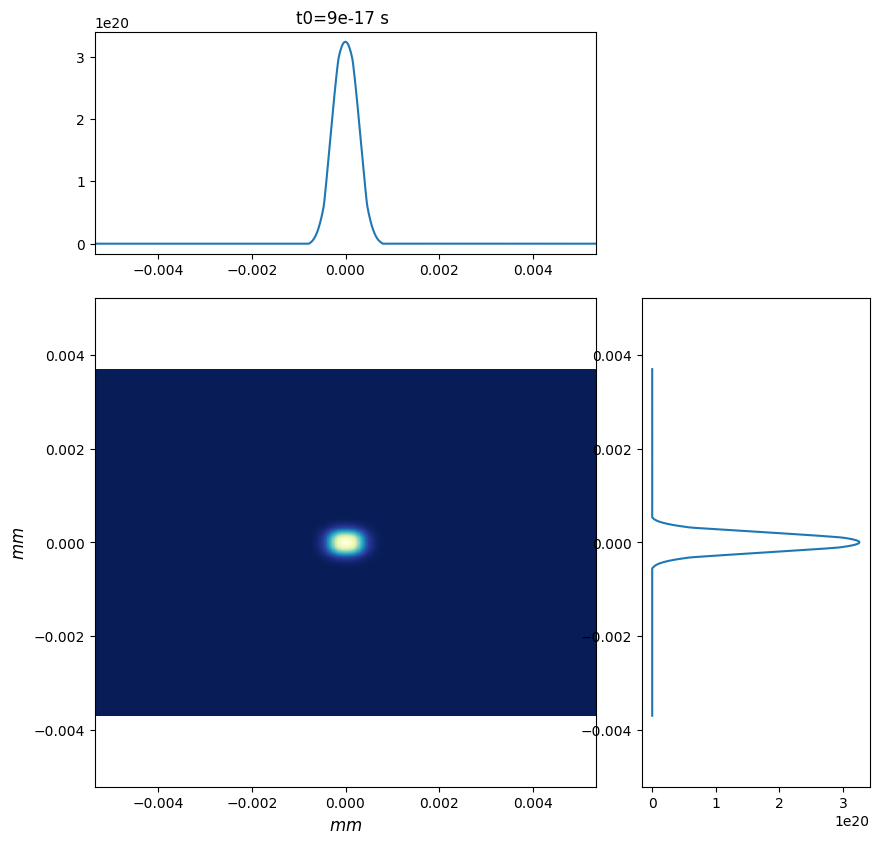

In [13]:
plot_intensity_map(wf)

In [15]:
### SASE pulse

initializing ocelot...


[INFO    ] imitating SASE radiation
[DEBUG   ] : using xlamds (wave.py:946)
[DEBUG   ] : E0 = 500.0 (wave.py:948)
[DEBUG   ] : dE = 0.2 (wave.py:949)
[INFO    ] : generating radiation field of shape(150, 51, 51)
[DEBUG   ] : : done in 0.07 sec (wave.py:924)
[DEBUG   ] : dfl.shape = (150, 51, 51) (wave.py:952)
[DEBUG   ] : time domain range = [0.0,  4.984164735335569e-05]m (wave.py:954)
[DEBUG   ] : frequency domain range = [498.1343283582089,  501.86567164179104]eV (wave.py:960)
[INFO    ] : generating 1d radiation field imitating SASE
[INFO    ] plotting radiation field (dfl)
[INFO    ] : done in 0.87 seconds


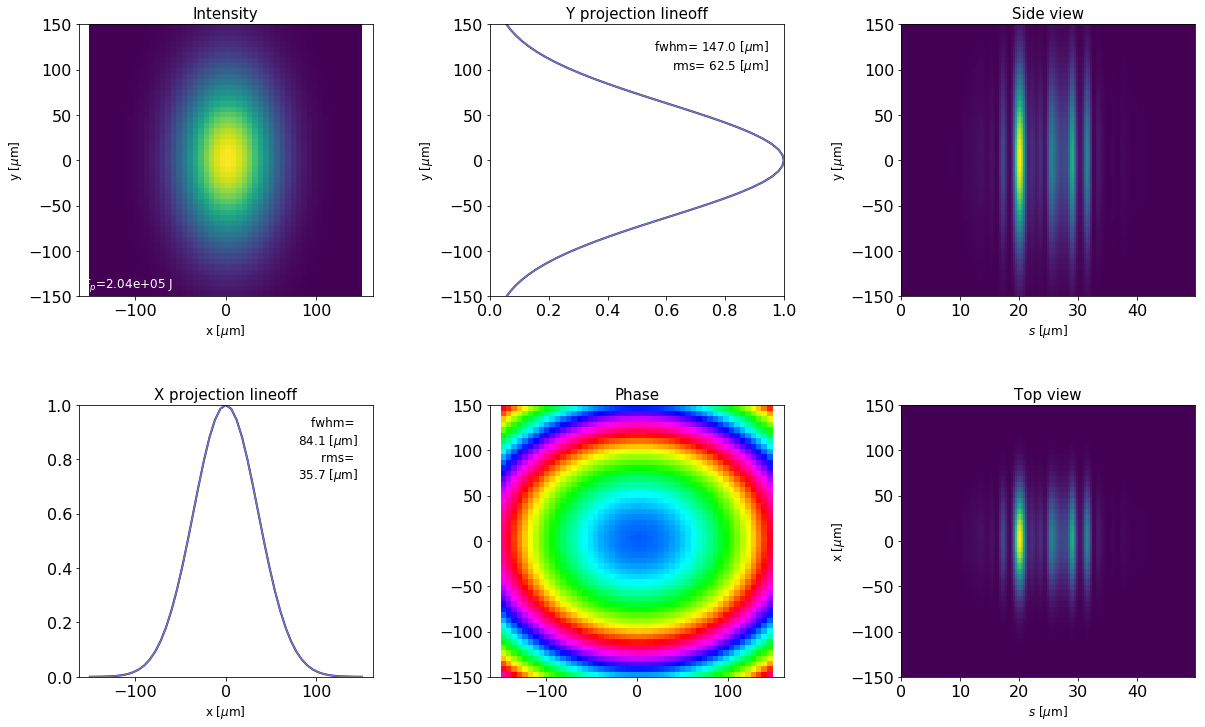

[INFO    ] plotting radiation field (dfl)
[DEBUG   ] : calculating dfl fft_z from t domain with mp (wave.py:261)
[DEBUG   ] : : done in 0.02 sec (wave.py:296)
[INFO    ] : done in 0.75 seconds


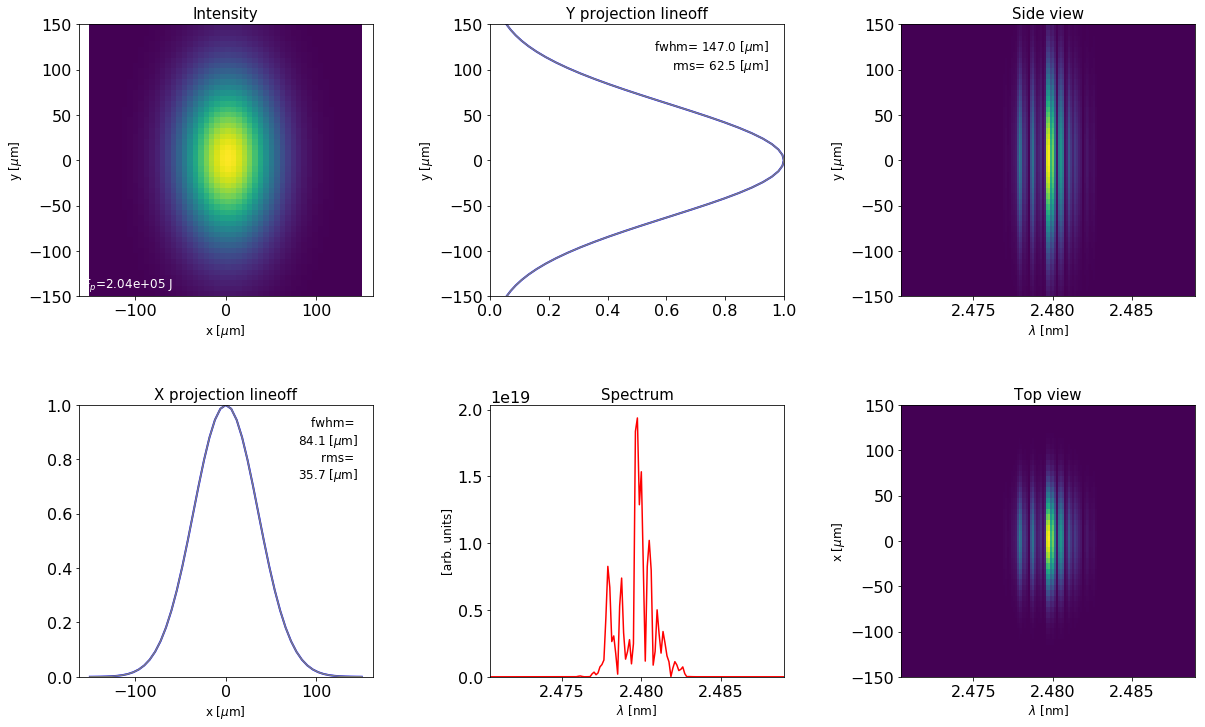

[INFO    ] plotting radiation field (dfl)
[DEBUG   ] : calculating fft_xy from s domain with mp (wave.py:302)
[DEBUG   ] : : done in 0.02 sec (wave.py:337)
[INFO    ] : done in 0.87 seconds


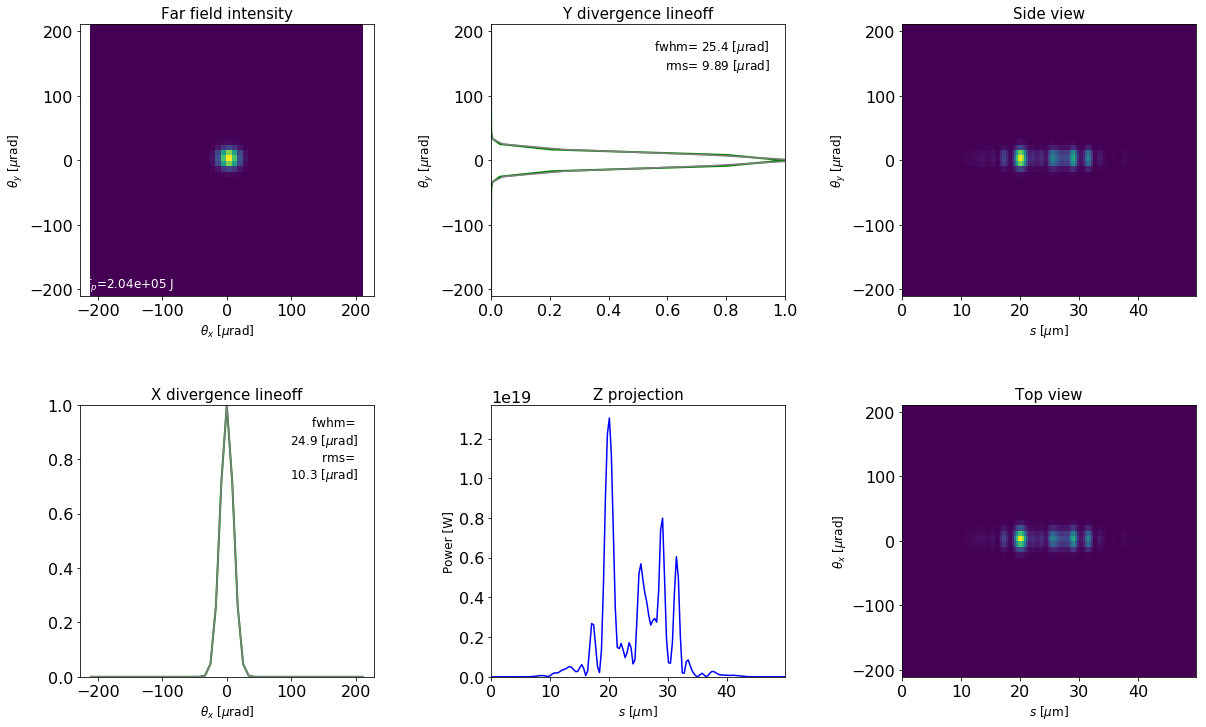

In [14]:

"""
Created on Mon Jun 18 20:27:41 2018

@author: sserkez
"""
import logging
from ocelot.common.globals import *
from ocelot.optics.wave import imitate_sase_dfl, wigner_dfl, dfl_waistscan
from ocelot.gui.genesis_plot import plot_dfl, plot_wigner, plot_dfl_waistscan

#ocelog.setLevel(logging.INFO)
_logger = logging.getLogger('ocelot.optics') 
_logger.setLevel(logging.DEBUG)

dfl = imitate_sase_dfl(h_eV_s * speed_of_light / 500, rho=2e-4, shape=(51,51,150), dgrid=(3e-4,3e-4,50e-6), power_rms=(20e-6,20e-6,5e-6), power_center=(0,0,None), power_angle=(0,0), power_waistpos=(3,6), wavelength=None, zsep=None, freq_chirp=0, en_pulse=None, power=1e6)
plot_dfl(dfl, fig_name='time', phase=True)
plot_dfl(dfl, domains='sf', fig_name='freq')
plot_dfl(dfl, domains='kt', fig_name='div')
#dfl.prop(3)
#plot_dfl(dfl, fig_name='after_prop')

#wig = wigner_dfl(dfl, pad=2)
#plot_wigner(wig)

#sc = dfl_waistscan(dfl,[0,1,2,3,5,6,10])
#plot_dfl_waistscan(sc)

In [31]:
import ocelot; ocelot.__file__

'/home/grotec/Codes/eucall-software/simex_platform/develop/lib/python3.4/ocelot/__init__.py'

In [32]:
!ls /home/grotec/Codes/eucall-software/simex_platform/develop/lib/python3.4/ocelot/optics

bragg.py  elements.py  parse_xop.py  utils.py
data	  __init__.py  ray.py	     wave.py


In [ ]:
# %load /home/grotec/Codes/eucall-software/simex_platform/develop/lib/python3.4/ocelot/optics/wave.py
'''
wave optics
'''

from numpy import random
from numpy.linalg import norm
import numpy as np
from numpy import inf, complex128, complex64
import numpy.fft as fft
# import matplotlib.pyplot as plt
import scipy.integrate as integrate
#import matplotlib.animation as animation
from copy import deepcopy
import time
import os


# from ocelot.optics.elements import *
from ocelot.common.globals import *
from ocelot.common.math_op import find_nearest_idx, fwhm, std_moment
from ocelot.common.py_func import filename_from_path
# from ocelot.optics.utils import calc_ph_sp_dens
#from ocelot.adaptors.genesis import *   #commented
# import ocelot.adaptors.genesis as genesis_ad
# GenesisOutput = genesis_ad.GenesisOutput
from ocelot.common.logging import *
_logger = logging.getLogger(__name__) 

import multiprocessing
nthread = multiprocessing.cpu_count()

try:
    import pyfftw
    fftw_avail = True
except ImportError:
    print("wave.py: module PYFFTW is not installed. Install it if you want speed up dfl wavefront calculations")
    fftw_avail = False

class RadiationField:
    '''
    3d or 2d coherent radiation distribution, *.fld variable is the same as Genesis dfl structure
    '''

    def __init__(self, shape=(0, 0, 0)):
        # self.fld=np.array([]) #(z,y,x)
        self.fld = np.zeros(shape, dtype=complex128)  # (z,y,x)
        self.dx = []
        self.dy = []
        self.dz = []
        self.xlamds = None  # carrier wavelength [m]
        self.domain_z = 't'  # longitudinal domain (t - time, f - frequency)
        self.domain_xy = 's'  # transverse domain (s - space, k - inverse space)
        self.filePath = ''

    def fileName(self):
        return filename_from_path(self.filePath)

    def copy_param(self, dfl1):
        self.dx = dfl1.dx
        self.dy = dfl1.dy
        self.dz = dfl1.dz
        self.xlamds = dfl1.xlamds
        self.domain_z = dfl1.domain_z
        self.domain_xy = dfl1.domain_xy
        self.filePath = dfl1.filePath

    def __getitem__(self, i):
        return self.fld[i]

    def __setitem__(self, i, fld):
        self.fld[i] = fld

    def shape(self):
        return self.fld.shape
    
    def domains(self):
        return self.domain_z, self.domain_xy

    def Lz(self):  # full transverse mesh size, 2*dgrid
        return self.dz * self.Nz()

    def Ly(self):  # full transverse mesh size, 2*dgrid
        return self.dy * self.Ny()


    def Lx(self):  # full longitudinal mesh size, nslice*zsep*xlamds
        return self.dx * self.Nx()

    def Nz(self):
        return self.fld.shape[0]

    def Ny(self):
        return self.fld.shape[1]

    def Nx(self):
        return self.fld.shape[2]

    def intensity(self):  # 3d intensity
        return self.fld.real**2 + self.fld.imag**2

    def int_z(self):  # intensity projection on z (power [W] or spectral density)
        return np.sum(self.intensity(), axis=(1, 2))

    def ang_z_onaxis(self):
        xn = int((self.Nx() + 1) / 2)
        yn = int((self.Ny() + 1) / 2)
        fld = self[:, yn, xn]
        return np.angle(fld)

    def int_y(self):
        return np.sum(self.intensity(), axis=(0, 2))

    def int_x(self):
        return np.sum(self.intensity(), axis=(0, 1))

    def int_xy(self):
        return np.swapaxes(np.sum(self.intensity(), axis=0), 1, 0)

    def int_zx(self):
        return np.sum(self.intensity(), axis=1)

    def int_zy(self):
        return np.sum(self.intensity(), axis=2)

    def E(self):  # energy in the pulse [J]
        if self.Nz() > 1:
            return np.sum(self.intensity()) * self.Lz() / self.Nz() / speed_of_light
        else:
            return np.sum(self.intensity())

    # propper scales in meters or 2 pi / meters
    def scale_kx(self):  # scale in meters or meters**-1
        if self.domain_xy == 's':  # space domain
            return np.linspace(-self.Lx() / 2, self.Lx() / 2, self.Nx())
        elif self.domain_xy == 'k':  # inverse space domain
            k = 2 * np.pi / self.dx
            return np.linspace(-k / 2, k / 2, self.Nx())
        else:
            raise AttributeError('Wrong domain_xy attribute')

    def scale_ky(self):  # scale in meters or meters**-1
        if self.domain_xy == 's':  # space domain
            return np.linspace(-self.Ly() / 2, self.Ly() / 2, self.Ny())
        elif self.domain_xy == 'k':  # inverse space domain
            k = 2 * np.pi / self.dy
            return np.linspace(-k / 2, k / 2, self.Ny())
        else:
            raise AttributeError('Wrong domain_xy attribute')

    def scale_kz(self):  # scale in meters or meters**-1
        if self.domain_z == 't':  # time domain
            return np.linspace(0, self.Lz(), self.Nz())
        elif self.domain_z == 'f':  # frequency domain
            dk = 2 * pi / self.Lz()
            k = 2 * pi / self.xlamds
            return np.linspace(k - dk / 2 * self.Nz(), k + dk / 2 * self.Nz(), self.Nz())
        else:
            raise AttributeError('Wrong domain_z attribute')

    def scale_x(self):  # scale in meters or radians
        if self.domain_xy == 's':  # space domain
            return self.scale_kx()
        elif self.domain_xy == 'k':  # inverse space domain
            return self.scale_kx() * self.xlamds / 2 / np.pi
        else:
            raise AttributeError('Wrong domain_xy attribute')

    def scale_y(self):  # scale in meters or radians
        if self.domain_xy == 's':  # space domain
            return self.scale_ky()
        elif self.domain_xy == 'k':  # inverse space domain
            return self.scale_ky() * self.xlamds / 2 / np.pi
        else:
            raise AttributeError('Wrong domain_xy attribute')

    def scale_z(self):  # scale in meters
        if self.domain_z == 't':  # time domain
            return self.scale_kz()
        elif self.domain_z == 'f':  # frequency domain
            return 2 * pi / self.scale_kz()
        else:
            raise AttributeError('Wrong domain_z attribute')

    def ph_sp_dens(self):
        if self.domain_z == 't':
            dfl = deepcopy(self)
            dfl.fft_z()
        else:
            dfl = self
        pulse_energy = dfl.E()
        spec0 = dfl.int_z()
        freq_ev = h_eV_s * speed_of_light / dfl.scale_z()
        freq_ev_mean = np.sum(freq_ev*spec0) / np.sum(spec0)
        n_photons = pulse_energy / q_e / freq_ev_mean
        spec = calc_ph_sp_dens(spec0, freq_ev, n_photons)
        return freq_ev, spec
        
    def curve_wavefront(self, r, domain_z=None):
        '''
        introduction of the additional 
        wavefront curvature with radius r
        
        r can be scalar or vector with self.Nz() points
        r>0 -> converging wavefront
        '''
        domains = domain_o_z, domain_o_xy = self.domain_z, self.domain_xy
        
        if domain_z == None:
            domain_z = domain_o_z

        if domain_z == 'f':
            self.to_domain('fs')
            x, y = np.meshgrid(self.scale_x(), self.scale_y())
            arg2 = x**2 + y**2
            k = 2 * np.pi / self.scale_z()
            if np.size(r) == 1:
                self.fld *= np.exp(-1j * k[:,np.newaxis,np.newaxis] / 2 * arg2[np.newaxis,:,:] / r)
            elif np.size(r) == self.Nz():
                self.fld *= np.exp(-1j * k[:,np.newaxis,np.newaxis] / 2 * arg2[np.newaxis,:,:] / r[:,np.newaxis,np.newaxis])
        
        elif domain_z=='t':
            self.to_domain('ts')
            x, y = np.meshgrid(self.scale_x(), self.scale_y())
            arg2 = x**2 + y**2
            k = 2 * np.pi / self.xlamds
            if np.size(r) == 1:
                self.fld *= np.exp(-1j * k / 2 * arg2 / r)[np.newaxis,:,:]
            elif np.size(r) == self.Nz():
                self.fld *= np.exp(-1j * k / 2 * arg2[np.newaxis,:,:] / r[:,np.newaxis,np.newaxis])
            else: 
                raise ValueError('wrong dimensions of radius of curvature')
        
        self.to_domain(domains)
    
    def to_domain(self, domains='ts', **kwargs):
        
        _logger.info('transforming radiation field to {} domain'.format(str(domains)))
        
        '''
        tranfers radiation to specified domains
        *domains is a string with one or two letters: 
            ("t" or "f") and ("s" or "k")
        where 
            't' (time); 'f' (frequency); 's' (space); 'k' (inverse space); 
        e.g.
            't'; 'f'; 's'; 'k'; 'ts'; 'fs'; 'tk'; 'fk'
        order does not matter
        
        **kwargs are passed down to self.fft_z and self.fft_xy
        '''
        dfldomain_check(domains)

        for domain in domains:
            domain_o_z, domain_o_xy = self.domain_z, self.domain_xy
            if domain in ['t', 'f'] and domain is not domain_o_z:
                self.fft_z(**kwargs)
            if domain in ['s', 'k'] and domain is not domain_o_xy:
                self.fft_xy(**kwargs)
    
    def fft_z(self, method='mp', nthread=multiprocessing.cpu_count(), debug=1):  # move to another domain ( time<->frequency )
        _logger.debug('calculating dfl fft_z from ' + self.domain_z + ' domain with ' + method)
        start = time.time()
        orig_domain = self.domain_z
    
        if nthread < 2:
            method = 'np'
    
        if orig_domain == 't':
            if method == 'mp' and fftw_avail:
                fft_exec = pyfftw.builders.fft(self.fld, axis=0, overwrite_input=True, planner_effort='FFTW_ESTIMATE', threads=nthread, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
                self.fld = fft_exec()
            else:
                self.fld = np.fft.fft(self.fld, axis=0)
            # else:
                # raise ValueError('fft method should be "np" or "mp"')
            self.fld = np.fft.ifftshift(self.fld, 0)
            self.fld /= np.sqrt(self.Nz())
            self.domain_z = 'f'
        elif orig_domain == 'f':
            self.fld = np.fft.fftshift(self.fld, 0)
            if method == 'mp' and fftw_avail:
                fft_exec = pyfftw.builders.ifft(self.fld, axis=0, overwrite_input=True, planner_effort='FFTW_ESTIMATE', threads=nthread, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
                self.fld = fft_exec()
            else:
                self.fld = np.fft.ifft(self.fld, axis=0)
    
                # else:
                # raise ValueError("fft method should be 'np' or 'mp'")
            self.fld *= np.sqrt(self.Nz())
            self.domain_z = 't'
        else:
            raise ValueError("domain_z value should be 't' or 'f'")
    
        t_func = time.time() - start
        if t_func < 60:
            _logger.debug(ind_str + 'done in %.2f sec' % (t_func))
        else:
            _logger.debug(ind_str + 'done in %.2f min' % (t_func / 60))
    
    
    def fft_xy(self, method='mp', nthread=multiprocessing.cpu_count(), debug=1):  # move to another domain ( spce<->inverse_space )
        _logger.debug('calculating fft_xy from ' + self.domain_xy + ' domain with ' + method)
        start = time.time()
        domain_orig = self.domain_xy
    
        if nthread < 2:
            method = 'np'
    
        if domain_orig == 's':
            if method == 'mp' and fftw_avail:
                fft_exec = pyfftw.builders.fft2(self.fld, axes=(1, 2), overwrite_input=False, planner_effort='FFTW_ESTIMATE', threads=nthread, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
                self.fld = fft_exec()
            else:
                self.fld = np.fft.fft2(self.fld, axes=(1, 2))
                # else:
                # raise ValueError("fft method should be 'np' or 'mp'")
            self.fld = np.fft.fftshift(self.fld, axes=(1, 2))
            self.fld /= np.sqrt(self.Nx() * self.Ny())
            self.domain_xy = 'k'
        elif domain_orig == 'k':
            self.fld = np.fft.ifftshift(self.fld, axes=(1, 2))
            if method == 'mp' and fftw_avail:
                fft_exec = pyfftw.builders.ifft2(self.fld, axes=(1, 2), overwrite_input=False, planner_effort='FFTW_ESTIMATE', threads=nthread, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
                self.fld = fft_exec()
            else:
                self.fld = np.fft.ifft2(self.fld, axes=(1, 2))
            # else:
                # raise ValueError("fft method should be 'np' or 'mp'")
            self.fld *= np.sqrt(self.Nx() * self.Ny())
            self.domain_xy = 's'
    
        else:
            raise ValueError("domain_xy value should be 's' or 'k'")
    
        t_func = time.time() - start
        if t_func < 60:
            _logger.debug(ind_str + 'done in %.2f sec' % (t_func))
        else:
            _logger.debug(ind_str + 'done in %.2f min' % (t_func / 60))
    
    
    def prop(self, z, fine=0, return_result=0, return_orig_domains=1, debug=1):
        '''
        Angular-spectrum propagation for fieldfile
    
        can handle wide spectrum
          (every slice in freq.domain is propagated 
           according to its frequency)
        no kx**2+ky**2<<k0**2 limitation
    
        dfl is the RadiationField() object
        z is the propagation distance in [m] 
        fine=1 is a flag for ~2x faster propagation. 
            no Fourier transform to frequency domain is done
            assumes no angular dispersion (true for plain FEL radiation)
            assumes narrow spectrum at center of xlamds (true for plain FEL radiation)
        
        return_result does not modify self, but returns result
        
        z>0 -> forward direction
        '''
        _logger.info('propagating dfl file by %.2f meters' % (z))
        
        if z == 0:
            _logger.debug(ind_str + 'z=0, returning original')
            if return_result:
                return self
            else:
                return
        
        start = time.time()
        
        domains = self.domains()
        
        if return_result:
            copydfl = deepcopy(self)
            copydfl, self = self, copydfl
        
       # domain_xy = self.domain_xy
       # domain_z = self.domain_z
    
        if fine==1:
            self.to_domain('kf')
        elif fine==-1:
            self.to_domain('kt')
        else:
            self.to_domain('k')
        # switch to inv-space/freq domain
       # if self.domain_xy == 's':
           # self.fft_xy(debug=debug)
       # if self.domain_z == 't' and fine:
           # self.fft_z(debug=debug)
    
        if self.domain_z == 'f':
            k_x, k_y = np.meshgrid(self.scale_kx(), self.scale_ky())
            for i in range(self.Nz()):
                k = self.scale_kz()[i]
                H = np.exp(1j * z * (np.sqrt(k**2 - k_x**2 - k_y**2) - k))
                self.fld[i, :, :] *= H
        else:
            k_x, k_y = np.meshgrid(self.scale_kx(), self.scale_ky())
            k = 2 * np.pi / self.xlamds
            H = np.exp(1j * z * (np.sqrt(k**2 - k_x**2 - k_y**2) - k))
            for i in range(self.Nz()):
                self.fld[i, :, :] *= H
    
        if return_orig_domains:
            self.to_domain(domains)
    
        t_func = time.time() - start
        _logger.debug(ind_str + 'done in %.2f sec' % t_func)
        
        if return_result:
            copydfl, self = self, copydfl
            return copydfl
            
    def prop_m(self, z, m=1, fine=0, return_result=0, return_orig_domains=1, debug=1):
        '''
        Angular-spectrum propagation for fieldfile
        
        can handle wide spectrum
          (every slice in freq.domain is propagated 
           according to its frequency)
        no kx**2+ky**2<<k0**2 limitation
    
        dfl is the RadiationField() object
        z is the propagation distance in [m]
        m is the output mesh size in terms of input mesh size (m = L_out/L_inp)
        fine==0 is a flag for ~2x faster propagation. 
            no Fourier transform to frequency domain is done
            assumes no angular dispersion (true for plain FEL radiation)
            assumes narrow spectrum at center of xlamds (true for plain FEL radiation)
    
        z>0 -> forward direction
        '''
        _logger.info('propagating dfl file by %.2f meters' % (z))
        
        if z == 0 and m == 1:
            _logger.debug(ind_str + 'z=0, returning original')
            if return_result:
                return self
            else:
                return
#        elif z == 0 and m != 1:
#            pass
        
        start = time.time()
        domains = self.domains()
        
        if return_result:
            copydfl = deepcopy(self)
            copydfl, self = self, copydfl
        
#        domain_xy = self.domain_xy
        domain_z = self.domain_z
        
        #q_multiply(dfl_out, (1-m) / z)
        if m != 1:
            self.curve_wavefront(-z / (1-m))
        
        if fine==1:
            self.to_domain('kf')
        elif fine==-1:
            self.to_domain('kt')
        else:
            self.to_domain('k')
       # if domain_xy == 's':
           # self.fft_xy(debug=debug)
       # if domain_z == 't' and fine:
           # self.fft_z(debug=debug)
            
        if z != 0:
            if self.domain_z == 'f':
                k = 2 * np.pi / self.xlamds
                self.curve_wavefront(m / z * (self.scale_kz() / k))
            else:
                self.curve_wavefront(m / z)
        
        self.dx *= m
        self.dy *= m
        
        # switch to original domain
       # if domain_xy == 's':
           # self.fft_xy(debug=debug)
       # if domain_z == 't' and fine:
           # self.fft_z(debug=debug)
#        self.to_domain('s')
        if return_orig_domains:
            self.to_domain(domains)
        
        if m != 1:
            self.curve_wavefront(-m * z / (m-1))
        
        t_func = time.time() - start
        _logger.debug(ind_str + 'done in %.2f sec' % (t_func))
        
        if return_result:
            copydfl, self = self, copydfl
            return copydfl
    
class WaistScanResults():

    def __init__(self):
        self.filePath = ''
        self.xlamds = None
        self.z_pos = np.array([])
        self.phdens_max = np.array([])
        self.phdens_onaxis = np.array([])
        self.fwhm_x = np.array([])
        self.fwhm_y = np.array([])
        self.std_x = np.array([])
        self.std_y = np.array([])
        self.z_maxint = None

    def fileName(self):
        return filename_from_path(self.filePath)
    
    
class TransferFunction:
    '''
    data container for Fourier Optics transfer functions
    '''
    def __init__(self):
        self.k = None # wave vector - 2*pi/wavelength
        self.tr = None # complex value of transmission - modulus*exp(-i*phase)
        self.ref = None # .. of reflection
        self.xlamds = None # carrier wavelength
        self.mid_k = None # center of feature in spectrum
        self.dk = None # width of feature in spectrum
    
    def ev(self):
        return self.k* h_eV_s/2/pi * speed_of_light
    
    def __mul__(self, f):
        if f.__class__ == TransferFunction:
            f2 = TransferFunction()
            f2.k = f.k
            f2.ev = f.ev
            # TODO check data grid alignment
            
            f2.tr = self.tr * f.tr
            f2.ref = self.ref * f.ref
            
            return f2
        return None

class StokesParameters:
    def __init__(self):
        self.sc = np.array([])
        self.s0 = np.array([])
        self.s1 = np.array([])
        self.s2 = np.array([])
        self.s3 = np.array([])
        
    def __getitem__(self,i):
        S = deepcopy(self)
        if self.s0.ndim == 1:
            S.sc = self.sc[i]
        S.s0 = self.s0[i]
        S.s1 = self.s1[i]
        S.s2 = self.s2[i]
        S.s3 = self.s3[i]
        return S
        
    def s_coh(self):
        #coherent part
        return np.sqrt(self.s1**2 + self.s2**2 + self.s3**2)
    def s_l(self):
        #linearly polarized part
        return np.sqrt(self.s1**2 + self.s2**2)
        #        self.s_coh = np.array([])
    def chi(self):
        # chi angle (p/4 = circular)
        return np.arctan(self.s3 / np.sqrt(self.s1**2 + self.s2**2)) / 2
    def psi(self):
        # psi angle 0 - horizontal, pi/2 - vertical
        psi = np.arctan(self.s2 / self.s1) / 2

        idx1 = np.where((self.s1<0) & (self.s2>0))
        idx2 = np.where((self.s1<0) & (self.s2<0))
        if size(psi) == 1:
            # continue
            # psi = psi
            if size(idx1): psi += np.pi/2
            if size(idx2): psi -= np.pi/2
        else:
            psi[idx1] += np.pi/2
            psi[idx2] -= np.pi/2
        return psi
        
def bin_stokes(S, bin_size):
    
    if type(S) != StokesParameters:
        raise ValueError('Not a StokesParameters object')
    
    S1 = StokesParameters()
    S1.sc = bin_scale(S.sc, bin_size)
    S1.s0 = bin_array(S.s0, bin_size)
    S1.s1 = bin_array(S.s1, bin_size)
    S1.s2 = bin_array(S.s2, bin_size)
    S1.s3 = bin_array(S.s3, bin_size)
    return S1
    
def calc_stokes_out(out1, out2, pol='rl', on_axis=True):
    if pol != 'rl':
        raise ValueError('Not implemented yet')
    
    if on_axis:
        a1=np.sqrt(np.array(out1.p_mid[:, -1])) # +
        a2=np.sqrt(np.array(out2.p_mid[:, -1])) # -
    else:
        a1=np.sqrt(np.array(out1.p_int[:, -1])) # +
        a2=np.sqrt(np.array(out2.p_int[:, -1])) # -
    
    f1=np.array(out1.phi_mid[:,-1])
    f2=np.array(out2.phi_mid[:,-1])
    if np.equal(out1.s, out2.s).all():
        s = out2.s
    else:
        raise ValueError('Different scales')
    
    E1x = a1 * np.exp(1j * f1)
    E1y = E1x * 1j
    E2x = a2 * np.exp(1j * f2)
    E2y = E2x * (-1j)
    
    Ex = (E1x + E2x) / np.sqrt(2)
    Ey = (E1y + E2y) / np.sqrt(2)
    
    S = calc_stokes(Ex,Ey,s)
    
    return S
    

def calc_stokes_dfl(dfl1, dfl2, pol='rl', mode=(0,0)):
    #mode: (average_longitudinally, sum_transversely)
    if pol != 'rl':
        raise ValueError('Not implemented yet')
    
    if len(dfl1.fld) != len(dfl2.fld):
        l1 = len(dfl1.fld)
        l2 = len(dfl2.fld)
        if l1 > l2:
            dfl1.fld = dfl1.fld[:-(l1-l2),:,:]
        else:
            dfl2.fld = dfl2.fld[:-(l2-l1),:,:]

    # if np.equal(dfl1.scale_z(), dfl2.scale_z()).all():
    s = dfl1.scale_z()
    # else:
        # raise ValueError('Different scales')
    
    Ex = (dfl1.fld + dfl2.fld) / np.sqrt(2)                #(E1x + E2x) /np.sqrt(2)
    Ey = (dfl1.fld * 1j + dfl2.fld * (-1j)) / np.sqrt(2)   #(E1y + E2y) /np.sqrt(2)
    
    S = calc_stokes(Ex,Ey,s)

    if mode[1]:
        S = sum_stokes_tr(S)
        # S.s0 = np.sum(S.s0,axis=(1,2))
        # S.s1 = np.sum(S.s1,axis=(1,2))
        # S.s2 = np.sum(S.s2,axis=(1,2))
        # S.s3 = np.sum(S.s3,axis=(1,2))
    
    if mode[0]:
        S = average_stokes_l(S)

    return S

    
    
def calc_stokes(Ex,Ey,s=None):
    
    if len(Ex) != len(Ey):
        raise ValueError('Ex and Ey dimentions do not match')
        
    if s is None:
        s = np.arange(len(Ex))
    
    Ex_ = np.conj(Ex)
    Ey_ = np.conj(Ey)
    
    Jxx = Ex * Ex_
    Jxy = Ex * Ey_
    Jyx = Ey * Ex_
    Jyy = Ey * Ey_
    
    del (Ex_,Ey_)
    
    S = StokesParameters()
    S.sc = s
    S.s0 = real(Jxx + Jyy)
    S.s1 = real(Jxx - Jyy)
    S.s2 = real(Jxy + Jyx)
    S.s3 = real(1j * (Jyx - Jxy))
    
    return S
    
def average_stokes_l(S,sc_range=None):
    
    if type(S) != StokesParameters:
        raise ValueError('Not a StokesParameters object')
    
    if sc_range is None:
        sc_range = [S.sc[0], S.sc[-1]]

    idx1 = np.where(S.sc >= sc_range[0])[0][0]
    idx2 = np.where(S.sc <= sc_range[-1])[0][-1]
    
    if idx1 == idx2:
        return S[idx1]
    
    S1 = StokesParameters()
    S1.sc = np.mean(S.sc[idx1:idx2], axis=0)
    S1.s0 = np.mean(S.s0[idx1:idx2], axis=0)
    S1.s1 = np.mean(S.s1[idx1:idx2], axis=0)
    S1.s2 = np.mean(S.s2[idx1:idx2], axis=0)
    S1.s3 = np.mean(S.s3[idx1:idx2], axis=0)
    return S1
    
def sum_stokes_tr(S):
    
    if type(S) != StokesParameters:
        raise ValueError('Not a StokesParameters object')
    if S.s0.ndim == 1:
        return S
    else:
        S1 = StokesParameters()
        S1.sc = S.sc
        S1.s0 = np.sum(S.s0,axis=(-1,-2))
        S1.s1 = np.sum(S.s1,axis=(-1,-2))
        S1.s2 = np.sum(S.s2,axis=(-1,-2))
        S1.s3 = np.sum(S.s3,axis=(-1,-2))
        
    return S1
    
    
class Spectrogram():
    '''
    spectrogram of the pulse
    (always positive!)
    '''
    def __init(self):
        self.spec = []
        self.s = []
        self.phen = []
        self.E = [] #pulse energy
        
    # def power(self):
        # return
        
    # def spectrum(self):
    
    
class WignerDistribution():
    '''
    calculated Wigner distribution (spectrogram) of the pulse
    in time/frequency domain as space/wavelength
    '''
    
    def __init__(self):
        # self.fld=np.array([]) #(z,y,x)
        self.field = []
        self.wig = []  # (wav,space)
        self.s = []  # space scale
        self.z = None # position along undulator (if applicable)
        self.phen = []  # photon energy
        self.xlamds = 0  # wavelength, [nm]
        self.filePath = ''
    
    @property
    def freq_lamd(self):
        return h_eV_s * speed_of_light * 1e9 / self.phen
    
    @freq_lamd.setter
    def freq_lamd(self,value):
        self.phen = h_eV_s * speed_of_light * 1e9 / value
    
    def power(self):
        return np.sum(self.wig,axis=0)
        
    def spectrum(self):
        return np.sum(self.wig,axis=1)
        
    def energy(self):
        return np.sum(self.wig)*abs(self.s[1]-self.s[0])/speed_of_light
        
    def fileName(self):
        return filename_from_path(self.filePath)
        
    def eval(self,method = 'mp'):
        
        # from ocelot.utils.xfel_utils import calc_wigner
        
        ds = self.s[1] - self.s[0]
        self.wig = calc_wigner(self.field, method=method, debug=1)
        phen = h_eV_s * (np.fft.fftfreq(self.s.size, d = ds / speed_of_light) + speed_of_light / self.xlamds)
        self.phen = np.fft.fftshift(phen, axes=0)
        # self.freq_lamd = h_eV_s * speed_of_light * 1e9 / freq_ev


def generate_dfl(xlamds, shape=(51,51,100), dgrid=(1e-3,1e-3,50e-6), power_rms=(0.1e-3,0.1e-3,5e-6), power_center=(0,0,None), power_angle=(0,0), power_waistpos=(0,0), wavelength=None, zsep=None, freq_chirp=0, en_pulse=None, power=1e6, **kwargs):
    '''
    generates RadiationField object 
    narrow-bandwidth, paraxial approximations
    
    xlamds [m] - central wavelength
    shape (x,y,z) - shape of field matrix (reversed) to dfl.fld
    dgrid (x,y,z) [m] - size of field matrix
    power_rms (x,y,z) [m] - rms size of the radiation distribution (gaussian)
    power_center (x,y,z) [m] - position of the radiation distribution
    power_angle (x,y) [rad] - angle of further radiation propagation
    power_waistpos (x,y) [m] downstrean location of the waist of the beam
    wavelength [m] - central frequency of the radiation, if different from xlamds
    zsep (integer) - distance between slices in z as zsep*xlamds
    freq_chirp [(1e9 nm)/(1e6 um)] = [m/m] - requency chirp of the beam around power_center[2]
    en_pulse, power = total energy or max power of the pulse, use only one
    '''
    
    start = time.time()

    if shape[2] == None:
        shape = (shape[0],shape[1],int(dgrid[2]/xlamds/zsep))
    
    _logger.info('generating radiation field of shape' + str(tuple(reversed(shape))))
    if 'energy' in kwargs:
        _logger.warn(ind_str + 'rename energy to en_pulse, soon arg energy will be deprecated')
        en_pulse = kwargs.pop('energy', 1)
    
    dfl = RadiationField(tuple(reversed(shape)))

    k = 2 * np.pi / xlamds

    dfl.xlamds = xlamds
    dfl.domain_z = 't'
    dfl.domain_xy = 's'
    dfl.dx = dgrid[0] / dfl.Nx()
    dfl.dy = dgrid[1] / dfl.Ny()
    if dgrid[2] is not None and zsep is not None:
        _logger.error('dgrid[2] or zsep should be None, since either determines longiduninal grid size')
    if dgrid[2] is not None:
        dz = dgrid[2] / dfl.Nz()
        zsep = int(dz/xlamds)
        dfl.dz = xlamds * zsep
    elif zsep is not None:
        dfl.dz = xlamds * zsep
    else:
        _logger.error('dgrid[2] or zsep should be not None, since they determine longiduninal grid size')

    rms_x, rms_y, rms_z = power_rms # intensity rms [m]
    xp, yp = power_angle
    x0, y0, z0 = power_center
    zx, zy = power_waistpos

    if z0 == None:
        z0 = dfl.Lz()/2

    xl = np.linspace(-dfl.Lx()/2, dfl.Lx()/2, dfl.Nx())
    yl = np.linspace(-dfl.Ly()/2, dfl.Ly()/2, dfl.Ny())
    zl = np.linspace(0, dfl.Lz(), dfl.Nz())
    z, y, x = np.meshgrid(zl,yl,xl, indexing='ij')

    qx = 1j * np.pi * (2 * rms_x)**2 / xlamds + zx
    qy = 1j * np.pi * (2 * rms_y)**2 / xlamds + zy
    qz = 1j * np.pi * (2 * rms_z)**2 / xlamds
    
    if wavelength.__class__ in [list, tuple, np.ndarray] and len(wavelength) == 2:
        freq_chirp = (wavelength[1] - wavelength[0]) / (z[-1,0,0] - z[0,0,0])
        _logger.debug(ind_str + 'wavelengths ', wavelength)
        _logger.debug(ind_str + 'z ', (z[-1,0,0], z[0,0,0]))
        _logger.debug(ind_str + 'calculated chirp ', freq_chirp)
        wavelength = np.mean([wavelength[0], wavelength[1]])
        
      
    if wavelength == None and xp == 0 and yp == 0:
        phase_chirp_lin = 0
    elif wavelength == None:
        phase_chirp_lin = x * np.sin(xp) + y * np.sin(yp)
    else:
        phase_chirp_lin = (z-z0)/dfl.dz * (dfl.xlamds-wavelength)/wavelength*xlamds * zsep + x * np.sin(xp) + y * np.sin(yp)


    if freq_chirp == 0:
        phase_chirp_quad = 0
    else:
        phase_chirp_quad = freq_chirp *((z-z0)/dfl.dz*zsep)**2 * xlamds / 2# / pi**2


    # if qz == 0 or qz == None:
        # dfl.fld = np.exp(-1j * k * ( (x-x0)**2/2/qx + (y-y0)**2/2/qy - phase_chirp_lin + phase_chirp_quad ) )
    # else:
    arg = np.zeros_like(z).astype('complex128')
    if qx != 0:
        arg += (x-x0)**2/2/qx
    if qy != 0:
        arg += (y-y0)**2/2/qy
    if abs(qz) == 0:
        idx = abs(zl-z0).argmin()
        zz = -1j * np.ones_like(arg)
        zz[idx,:,:] = 0
        arg += zz
    else:
        arg += (z-z0)**2/2/qz
        # print(zz[:,25,25])
        
    if phase_chirp_lin != 0:
        arg -= phase_chirp_lin
    if phase_chirp_quad != 0:
        arg += phase_chirp_quad
    dfl.fld = np.exp(-1j * k * arg) #  - (grid[0]-z0)**2/qz 
    # dfl.fld = np.exp(-1j * k * ( (x-x0)**2/2/qx + (y-y0)**2/2/qy + (z-z0)**2/2/qz - phase_chirp_lin + phase_chirp_quad) ) #  - (grid[0]-z0)**2/qz 


    if en_pulse != None and power == None:
        dfl.fld *= np.sqrt(en_pulse / dfl.E())
    elif en_pulse == None and power != None:
        dfl.fld *= np.sqrt(power / np.amax(dfl.int_z()))
    else:
        raise ValueError('Either en_pulse or power should be defined')

    dfl.filePath = ''

    t_func = time.time() - start
    _logger.debug(ind_str + 'done in %.2f sec' % (t_func))
    
    return dfl


def imitate_sase_dfl(xlamds, rho=2e-4, **kwargs):
    '''
    imitation of SASE radiation in 3D
    
    xlamds - wavelength of the substracted fast-varying component
    rho - half of the expected FEL bandwidth
    **kwargs identical to generate_dfl()
    
    returns RadiationField object
    '''
    
    _logger.info('imitating SASE radiation')
    if kwargs.pop('wavelength', None) is not None:
        E0 = h_eV_s * speed_of_light / kwargs.pop('wavelength')
        _logger.debug(ind_str + 'using wavelength')
    else:
        E0 = h_eV_s * speed_of_light / xlamds
        _logger.debug(ind_str + 'using xlamds')
    dE = E0 * 2 * rho
    _logger.debug(ind_str + 'E0 = {}'.format(E0))
    _logger.debug(ind_str + 'dE = {}'.format(dE))
    dfl = generate_dfl(xlamds, **kwargs)
    
    _logger.debug(ind_str + 'dfl.shape = {}'.format(dfl.shape()))
    td_scale = dfl.scale_z()
    _logger.debug(ind_str + 'time domain range = [{},  {}]m'.format(td_scale[0],td_scale[-1]))
    
    dk = 2 * np.pi / dfl.Lz()
    k = 2 * np.pi / dfl.xlamds
    fd_scale_ev = h_eV_s * speed_of_light * (np.linspace(k - dk / 2 * dfl.Nz(), k + dk / 2 * dfl.Nz(), dfl.Nz())) / 2 / np.pi
    fd_env = np.exp(-(fd_scale_ev - E0)**2 / 2 / (dE)**2)
    _logger.debug(ind_str + 'frequency domain range = [{},  {}]eV'.format(fd_scale_ev[0],fd_scale_ev[-1]))
    
    _, td_envelope, _, _ = imitate_1d_sase_like(td_scale=td_scale, td_env=np.ones_like(td_scale), fd_scale=fd_scale_ev, fd_env=fd_env, td_phase = None, fd_phase = None, phen0 = None, en_pulse = 1, fit_scale = 'td', n_events = 1)
 
    dfl.fld *= td_envelope[:, :, np.newaxis]
    
    return dfl


def dfl_ap(dfl, ap_x=None, ap_y=None, debug=1):
    '''
    aperture the radaition in either domain
    '''
    _logger.info('applying aperture to dfl')
        
    if np.size(ap_x) == 1:
        ap_x = [-ap_x/2, ap_x/2]
    if np.size(ap_y) == 1:
        ap_y = [-ap_y/2, ap_y/2]
        
    idx_x = np.where( (dfl.scale_x() >= ap_x[0]) & (dfl.scale_x() <= ap_x[1]) )[0]
    idx_x1 = idx_x[0]
    idx_x2 = idx_x[-1]
    
    idx_y = np.where( (dfl.scale_y() >= ap_y[0]) & (dfl.scale_y() <= ap_y[1]) )[0]
    idx_y1 = idx_y[0]
    idx_y2 = idx_y[-1]
    
    mask = np.zeros_like(dfl.fld[0, :, :])
    mask[idx_x1:idx_x2, idx_y1:idx_y2] = 1
    mask_idx = np.where(mask == 0)
    
    # dfl_out = deepcopy(dfl)
    dfl_energy_orig = dfl.E()
    dfl.fld[:, mask_idx[0], mask_idx[1]] = 0
    
    _logger.info(ind_str + 'done, %.2f%% energy lost' %( (dfl_energy_orig - dfl.E()) / dfl_energy_orig * 100 ))
    # tmp_fld = dfl.fld[:,idx_x1:idx_x2,idx_y1:idx_y2]
    
    # dfl_out.fld[:] = np.zeros_like(dfl_out.fld)
    # dfl_out.fld[:,idx_x1:idx_x2,idx_y1:idx_y2] = tmp_fld
    return dfl
    
    

def dfl_prop(dfl, z, fine=1, debug=1):
    '''
    LEGACY, WILL BE DEPRECATED, SEE METHOD
    
    Fourier propagator for fieldfile

    can handle wide spectrum
      (every slice in freq.domain is propagated 
       according to its frequency)
    no kx**2+ky**2<<k0**2 limitation

    dfl is the RadiationField() object
    z is the propagation distance in [m] 
    fine==0 is a flag for ~2x faster propagation. 
        no Fourier transform to frequency domain is done
        assumes no angular dispersion (true for plain FEL radiation)
        assumes narrow spectrum at center of xlamds (true for plain FEL radiation)

    returns RadiationField() object

    z>0 ==> forward
    '''
    
    
    
    print('propagating dfl file by %.2f meters' % (z))
    
    _logger.warning(ind_str + 'dfl_prop will be deprecated, use method instead')
    
    if z == 0:
        print('      returning original')
        return dfl
    
    start = time.time()

    dfl_out = deepcopy(dfl)
    domain_xy = dfl.domain_xy
    domain_z = dfl.domain_z

    # switch to inv-space/freq domain
    if dfl_out.domain_xy == 's':
        dfl_out = dfl_fft_xy(dfl_out, debug=debug)
    if dfl_out.domain_z == 't' and fine:
        dfl_out = dfl_fft_z(dfl_out, debug=debug)

    if fine:
        k_x, k_y = np.meshgrid(dfl_out.scale_kx(), dfl_out.scale_ky())
        for i in range(dfl_out.Nz()):
            k = dfl_out.scale_kz()[i]
            H = np.exp(1j * z * (np.sqrt(k**2 - k_x**2 - k_y**2) - k))
            dfl_out.fld[i, :, :] *= H
    else:
        k_x, k_y = np.meshgrid(dfl_out.scale_kx(), dfl_out.scale_ky())
        k = 2 * np.pi / dfl_out.xlamds
        H = np.exp(1j * z * (np.sqrt(k**2 - k_x**2 - k_y**2) - k))
        for i in range(dfl_out.Nz()):
            dfl_out.fld[i, :, :] *= H

    # switch to original domain
    if domain_xy == 's':
        dfl_out = dfl_fft_xy(dfl_out, debug=debug)
    if domain_z == 't' and fine:
        dfl_out = dfl_fft_z(dfl_out, debug=debug)

    t_func = time.time() - start
    if debug > 0:
        print('      done in %.2f ' % t_func + 'sec')

    return dfl_out


def dfl_waistscan(dfl, z_pos, projection=0, debug=1):
    '''
    propagates the RadaitionField object dfl 
    through the sequence of positions z_pos
    and calculates transverse distribution parameters
    such as peak photon density and sizes in both dimensions

    if projection==1, then size of projection is calculated
        otherwise - size across the central line passing through the mesh center
    '''
    _logger.info('scanning dfl waist in range %s meters' % (str(z_pos)))
    start = time.time()

    sc_res = WaistScanResults()
    sc_res.xlamds = dfl.xlamds
    sc_res.filePath = dfl.filePath

    for z in z_pos:

        _logger.info(ind_str + 'scanning at z = %.2f m' % (z))
        
        I_xy = dfl.prop(z, fine=0, debug=0, return_result=1).int_xy()  # integrated xy intensity
        

        scale_x = dfl.scale_x()
        scale_y = dfl.scale_y()
        center_x = np.int((I_xy.shape[0] + 1) / 2)
        center_y = np.int((I_xy.shape[1] + 1) / 2)

        if projection:
            I_x = np.sum(I_xy, axis=1)
            I_y = np.sum(I_xy, axis=0)
        else:
            I_x = I_xy[:, center_y]
            I_y = I_xy[center_x, :]

        sc_res.z_pos = np.append(sc_res.z_pos, z)
        sc_res.phdens_max = np.append(sc_res.phdens_max, np.amax(I_xy))
        
        _logger.debug(ind_str + 'phdens_max = %.2e' % (np.amax(I_xy)))
        
        sc_res.phdens_onaxis = np.append(sc_res.phdens_onaxis, I_xy[center_x, center_y])
        sc_res.fwhm_x = np.append(sc_res.fwhm_x, fwhm(scale_x, I_x))
        sc_res.fwhm_y = np.append(sc_res.fwhm_y, fwhm(scale_y, I_y))
        sc_res.std_x = np.append(sc_res.std_x, std_moment(scale_x, I_x))
        sc_res.std_y = np.append(sc_res.std_y, std_moment(scale_y, I_y))

        sc_res.z_max_phdens = sc_res.z_pos[np.argmax(sc_res.phdens_max)]

    t_func = time.time() - start
    _logger.debug(ind_str + 'done in %.2f sec' % t_func)

    return sc_res


def dfl_interp(dfl, interpN=(1, 1), interpL=(1, 1), newN=(None, None), newL=(None, None), method='cubic', debug=1):
    ''' 
    2d interpolation of the coherent radiation distribution 
    interpN and interpL define the desired interpolation coefficients for  
    transverse point __density__ and transverse mesh __size__ correspondingly 
    newN and newL define the final desire number of points and size of the mesh 
    when newN and newL are not None interpN and interpL values are ignored 
    coordinate convention is (x,y) 
    '''
    from scipy.interpolate import interp2d

    _logger.info('interpolating radiation file')
    start_time = time.time()
    
    E1 = dfl.E()

    # in case if interpolation is the same in both dimentions
    if np.size(interpN) == 1:
        interpN = (interpN, interpN)
    if np.size(interpL) == 1:
        interpL = (interpL, interpL)
    if np.size(newN) == 1:
        newN = (newN, newN)
    if np.size(newL) == 1:
        newL = (newL, newL)

    if (interpN == (1, 1) and interpL == (1, 1) and newN == (None, None) and newL == (None, None)) or \
       (interpN == (1, 1) and interpL == (1, 1) and newN == (dfl.Nx(), dfl.Ny()) and newL == (dfl.Lx(), dfl.Ly())):
        _logger.info(ind_str + 'no interpolation required')
        return

    # calculate new mesh parameters only if not defined explicvitly
    if newN == (None, None) and newL == (None, None):
        interpNx = interpN[0]
        interpNy = interpN[1]
        interpLx = interpL[0]
        interpLy = interpL[1]

        if interpNx == 0 or interpLx == 0 or interpNy == 0 or interpLy == 0:
            raise ValueError(ind_str + 'interpolation values cannot be 0')
            # place exception
        elif interpNx == 1 and interpNy == 1 and interpLx == 1 and interpLy == 1:
            _logger.info(ind_str + 'no interpolation required, returning original')
            return
            
        
        # elif interpNx == 1 and interpNy == 1 and interpLx <= 1 and interpLy <= 1:
            # implement pad or cut if Lx1/Nx1==Lx2/Nx2 and Ly1/Ny1==Ly2/Ny2:
            # print('      cutting original')
            # ny1=int((Ny1-Ny2)/2)
            # ny2=int(Ny1-(Ny1-Ny2)/2)
            # nx1=int((Nx1-Nx2)/2)
            # nx2=int(Nx1-(Nx1-Nx2)/2)
            # dfl.fld=dfl.fld[:,ny1:ny2,nx1:nx2]
            # return dfl
        
        else:
            
            Nx2 = int(dfl.Nx() * interpNx * interpLx)
            if Nx2 % 2 == 0 and Nx2 > dfl.Nx():
                Nx2 -= 1
            if Nx2 % 2 == 0 and Nx2 < dfl.Nx():
                Nx2 += 1
            
            
            Ny2 = int(dfl.Ny() * interpNy * interpLy)
            if Ny2 % 2 == 0 and Ny2 > dfl.Ny():
                Ny2 -= 1
            if Ny2 % 2 == 0 and Ny2 < dfl.Ny():
                Ny2 += 1

            
            Lx2 = dfl.Lx() * interpLx
            Ly2 = dfl.Ly() * interpLy

    else:
        # redo to maintain mesh density
        if newN[0] != None:
            Nx2 = newN[0]
        else:
            Nx2 = dfl.Nx()

        if newN[1] != None:
            Ny2 = newN[1]
        else:
            Ny2 = dfl.Ny()

        if newL[0] != None:
            Lx2 = newL[0]
        else:
            Lx2 = dfl.Lx()

        if newL[1] != None:
            Ly2 = newL[1]
        else:
            Ly2 = dfl.Ly()
            
    Lx1, Ly1 = dfl.Lx(), dfl.Ly()
    Nx1, Ny1 = dfl.Nx(), dfl.Ny()
    
    # _logger.debug(ind_str + 'old L=' + str((dfl.Lx(), dfl.Ly())))
    # _logger.debug(ind_str + 'new L=' + str(newL))
    # _logger.debug(ind_str + 'old N=' + str((dfl.Nx(), dfl.Ny())))
    # _logger.debug(ind_str + 'new N=' + str(newN))
    
    _logger.debug(ind_str + 'Lx1=%e, Ly1=%e' %(Lx1,Ly1))
    _logger.debug(ind_str + 'Lx2=%e, Ly2=%e' %(Lx2,Ly2))
    _logger.debug(ind_str + 'Nx1=%s, Ny1=%s' %(Nx1,Ny1))
    _logger.debug(ind_str + 'Nx2=%s, Ny2=%s' %(Nx2,Ny2))
    
    
    xscale1 = np.linspace(-Lx1 / 2, Lx1 / 2, Nx1)
    yscale1 = np.linspace(-Ly1 / 2, Ly1 / 2, Ny1)
    xscale2 = np.linspace(-Lx2 / 2, Lx2 / 2, Nx2)
    yscale2 = np.linspace(-Ly2 / 2, Ly2 / 2, Ny2)

    ix_min = np.where(xscale1 >= xscale2[0])[0][0]
    ix_max = np.where(xscale1 <= xscale2[-1])[-1][-1]
    iy_min = np.where(yscale1 >= yscale2[0])[0][0]
    iy_max = np.where(yscale1 <= yscale2[-1])[-1][-1]
    _logger.debug(ind_str + 'energy before interpolation ' + str(dfl.E()))
    #interp_func = rgi((zscale1,yscale1,xscale1), dfl.fld, fill_value=0, bounds_error=False, method='nearest')
    fld2 = []
    for nslice, fslice in enumerate(dfl.fld):
        _logger.log(5, ind_str + 'slice %s' %(nslice))
        re_func = interp2d(xscale1, yscale1, np.real(fslice), fill_value=0, bounds_error=False, kind=method)
        im_func = interp2d(xscale1, yscale1, np.imag(fslice), fill_value=0, bounds_error=False, kind=method)
        fslice2 = re_func(xscale2, yscale2) + 1j * im_func(xscale2, yscale2)
        P1 = sum(sum(abs(fslice[iy_min:iy_max, ix_min:ix_max])**2))
        P2 = sum(sum(abs(fslice2)**2))
        # print(P1, P2)
        _logger.log(5, ind_str + 'P1,P2 = %e %e' %(P1,P2))
        
        if P2!=0:
            fslice2 = fslice2 * np.sqrt(P1 / P2)
        else:
            fslice2 = fslice2 * 0
        
        fld2.append(fslice2)

    # dfl2 = deepcopy(dfl)
    # dfl2=RadiationField()
    
    _logger.debug(ind_str + 'new shape = (%i %i %i)' %(len(fld2), fslice2.shape[0], fslice2.shape[1]))
    
    dfl.fld = np.array(fld2)
    dfl.dx = Lx2 / dfl.Nx()
    dfl.dy = Ly2 / dfl.Ny()
    # dfl2.fileName=dfl.fileName+'i'
    # dfl2.filePath=dfl.filePath+'i'
    E2 = dfl.E()
    _logger.info(ind_str + '%.2f%% energy cut' %( (E1-E2) / E1 * 100 ))
    _logger.debug(ind_str + 'energy after interpolation ' + str(E2))
    _logger.debug(ind_str + 'done in %.2f sec' % (time.time() - start_time))

    # return dfl


def dfl_shift_z(dfl, s, set_zeros=1):
    '''
    shift the radiation within the window in time domain
    dfl - initial RadiationField object
    s - longitudinal offset value in meters
    set_zeros - to set the values outside the time window to zeros
    '''
    assert dfl.domain_z == 't', 'dfl_shift_z works only in time domain!'
    shift_n = int(s / dfl.dz)
    _logger.info('shifting dfl forward by %.2f um (%.0f slices)' % (s * 1e6, shift_n))
    if shift_n == 0:
        _logger.info(ind_str + 's=0, returning original')
        return
    else:
        start = time.time()
        dfl.fld = np.roll(dfl.fld, shift_n, axis=0)
        if set_zeros:
            if shift_n > 0:
                dfl.fld[:shift_n, :, :] = 0
            if shift_n < 0:
                dfl.fld[shift_n:, :, :] = 0
        t_func = time.time() - start
        # return dfl
    _logger.debug(ind_str + 'done in %.2f ' % t_func + 'sec')

# def dfl_pad_z_old(dfl, padn):
    # assert np.mod(padn, 1) == 0, 'pad should be integer'
    # start = time.time()

    # if padn > 1:
        # print('    padding dfl by ' + str(padn))
        # padn_n = int((padn - 1) / 2 * dfl.Nz())  # number of slices to add before and after
        # dfl_pad = RadiationField((dfl.Nz() + 2 * padn_n, dfl.Ny(), dfl.Nx()))
        # dfl_pad.copy_param(dfl)
        # dfl_pad.fld[padn_n:-padn_n, :, :] = dfl.fld
    # elif padn < -1:
        # padn = abs(padn)
        # print('    de-padding dfl by ' + str(padn))
        # padn_n = dfl.Nz() / padn * ((padn - 1) / 2)
        # dfl_pad = RadiationField()
        # dfl_pad.copy_param(dfl)
        # dfl_pad.fld = dfl.fld[padn_n:-padn_n, :, :]
    # else:
        # print('    padding dfl by ' + str(padn))
        # print('      pass')
        # return dfl

    # t_func = time.time() - start
    # if t_func < 60:
        # print('      done in %.2f ' % t_func + 'sec')
    # else:
        # print('      done in %.2f ' % t_func / 60 + 'min')
    # return dfl_pad

def dfl_pad_z(dfl, padn):
    assert np.mod(padn, 1) == 0, 'pad should be integer'
    start = time.time()

    if padn > 1:
        padn_n = int(padn  * dfl.Nz())  # new number of slices
        _logger.info('padding dfl by {:} from {:} to {:}'.format(padn, dfl.Nz(), padn_n))
        dfl_pad = RadiationField( (padn_n, dfl.Ny(), dfl.Nx()) )
        dfl_pad.copy_param(dfl)
        dfl_pad.fld[-dfl.Nz():, :, :] = dfl.fld
        dfl = dfl_pad
    elif padn < -1:
        padn = abs(padn)
        padn_n = int(dfl.Nz() / padn)  # new number of slices
        _logger.info('de-padding dfl by {:} from {:} to {:}'.format(padn, dfl.Nz(), padn_n))
        dfl_pad = RadiationField()
        dfl_pad.copy_param(dfl)
        dfl_pad.fld = dfl.fld[-padn_n:, :, :]
        dfl = dfl_pad
    else:
        _logger.info('padding dfl by {:}'.format(padn))
        _logger.info(ind_str + 'padn=1, passing')

    t_func = time.time() - start
    if t_func < 60:
        _logger.debug(ind_str + 'done in {:.2f} sec'.format(t_func))
    else:
        _logger.debug(ind_str + 'done in {:.2f} min'.format(t_func/60))
    # return dfl_pad

def dfl_cut_z(dfl,z=[-np.inf,np.inf],debug=1):
    
    _logger.info('cutting radiation file')
        
    if dfl.__class__ != RadiationField:
        raise ValueError('wrong radiation object: should be RadiationField')

    z = np.array(z)
    z.sort()
    z_sc = dfl.scale_z()
    idx1 = np.where(z_sc > z[0])[0][0]
    idx2 = np.where(z_sc < z[1])[0][-1]
    # dfl_cut = RadiationField()
    # dfl_cut.copy_param(dfl)
    dfl.fld = dfl.fld[idx1:idx2]

    _logger.debug(ind_str + 'done')

def dfl_fft_z(dfl, method='mp', nthread=multiprocessing.cpu_count(), debug=1):  # move to another domain ( time<->frequency )
    '''
    LEGACY, WILL BE DEPRECATED, SEE METHOD
    '''
    if debug > 0:
        print('      calculating fft_z from ' + dfl.domain_z + ' domain with ' + method)
    
    _logger.warning(ind_str + 'dfl_fft_z will be deprecated, use method instead')
    
    start = time.time()
    dfl_fft = RadiationField(dfl.shape())
    dfl_fft.copy_param(dfl)

    if nthread < 2:
        method = 'np'

    if dfl.domain_z == 't':
        if method == 'mp' and fftw_avail:
            fft = pyfftw.builders.fft(dfl.fld, axis=0, overwrite_input=False, planner_effort='FFTW_ESTIMATE', threads=nthread, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
            dfl_fft.fld = fft()
        else:
            dfl_fft.fld = np.fft.fft(dfl.fld, axis=0)
        # else:
            # raise ValueError('fft method should be "np" or "mp"')
        dfl_fft.fld = np.fft.ifftshift(dfl_fft.fld, 0)
        dfl_fft.fld /= np.sqrt(dfl_fft.Nz())
        dfl_fft.domain_z = 'f'
    elif dfl.domain_z == 'f':
        dfl_fft.fld = np.fft.fftshift(dfl.fld, 0)
        if method == 'mp' and fftw_avail:
            fft = pyfftw.builders.ifft(dfl_fft.fld, axis=0, overwrite_input=False, planner_effort='FFTW_ESTIMATE', threads=nthread, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
            dfl_fft.fld = fft()
        else:
            dfl_fft.fld = np.fft.ifft(dfl_fft.fld, axis=0)

            # else:
            # raise ValueError("fft method should be 'np' or 'mp'")
        dfl_fft.fld *= np.sqrt(dfl_fft.Nz())
        dfl_fft.domain_z = 't'
    else:
        raise ValueError("domain_z value should be 't' or 'f'")

    if debug > 0:
        t_func = time.time() - start
        if t_func < 60:
            print('        done in %.2f sec' %(t_func))
        else:
            print('        done in %.2f min' %(t_func / 60))
    return dfl_fft


def dfl_fft_xy(dfl, method='mp', nthread=multiprocessing.cpu_count(), debug=1):  # move to another domain ( spce<->inverse_space )
    '''
    LEGACY, WILL BE DEPRECATED, SEE METHOD
    '''
    if debug > 0:
        print('      calculating fft_xy from ' + dfl.domain_xy + ' domain with ' + method)
    
    _logger.warning(ind_str + 'dfl_fft_xy will be deprecated, use method instead')
    
    start = time.time()
    dfl_fft = RadiationField(dfl.shape())
    dfl_fft.copy_param(dfl)

    if nthread < 2:
        method = 'np'

    if dfl.domain_xy == 's':
        if method == 'mp' and fftw_avail:
            fft = pyfftw.builders.fft2(dfl.fld, axes=(1, 2), overwrite_input=False, planner_effort='FFTW_ESTIMATE', threads=nthread, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
            dfl_fft.fld = fft()
        else:
            dfl_fft.fld = np.fft.fft2(dfl.fld, axes=(1, 2))
            # else:
            # raise ValueError("fft method should be 'np' or 'mp'")
        dfl_fft.fld = np.fft.fftshift(dfl_fft.fld, axes=(1, 2))
        dfl_fft.fld /= np.sqrt(dfl_fft.Nx() * dfl_fft.Ny())
        dfl_fft.domain_xy = 'k'
    elif dfl.domain_xy == 'k':
        dfl_fft.fld = np.fft.ifftshift(dfl.fld, axes=(1, 2))
        if method == 'mp' and fftw_avail:
            fft = pyfftw.builders.ifft2(dfl_fft.fld, axes=(1, 2), overwrite_input=False, planner_effort='FFTW_ESTIMATE', threads=nthread, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
            dfl_fft.fld = fft()
        else:
            dfl_fft.fld = np.fft.ifft2(dfl_fft.fld, axes=(1, 2))
        # else:
            # raise ValueError("fft method should be 'np' or 'mp'")
        dfl_fft.fld *= np.sqrt(dfl_fft.Nx() * dfl_fft.Ny())
        dfl_fft.domain_xy = 's'

    else:
        raise ValueError("domain_xy value should be 's' or 'k'")

    if debug > 0:
        t_func = time.time() - start
        if t_func < 60:
            print('        done in %.2f ' % t_func + 'sec')
        else:
            print('        done in %.2f ' % t_func / 60 + 'min')
    return dfl_fft


def dfl_trf(dfl, trf, mode, dump_proj=False):
    '''
    Multiplication of radiation field by given transfer function (transmission or ferlection, given by mode)
    dfl is RadiationField() object (will be mutated)
    trf is TransferFunction() object
    mode is either 'tr' for transmission
                or 'ref' for reflection
    '''
    # assert dfl.domain_z == 'f', 'dfl_trf works only in frequency domain!'
    _logger.info('multiplying dfl by trf')
    start = time.time()
    # assert trf.__class__==TransferFunction,'Wrong TransferFunction class'
    assert dfl.domain_z == 'f', 'wrong dfl domain (must be frequency)!'
    if mode == 'tr':
        filt = trf.tr
    elif mode == 'ref':
        filt = trf.ref
    else:
        raise AttributeError('Wrong z_domain attribute')
    filt_lamdscale = 2 * np.pi / trf.k
    if min(dfl.scale_z()) > max(filt_lamdscale) or max(dfl.scale_z()) < min(filt_lamdscale):
        raise ValueError('frequency scales of dfl and transfer function do not overlap')

    # filt_interp_re = np.flipud(np.interp(np.flipud(dfl.scale_z()), np.flipud(filt_lamdscale), np.flipud(np.real(filt))))
    # filt_interp_im = np.flipud(np.interp(np.flipud(dfl.scale_z()), np.flipud(filt_lamdscale), np.flipud(np.imag(filt))))
    # filt_interp = filt_interp_re - 1j * filt_interp_im
    # del filt_interp_re, filt_interp_im
    filt_interp_abs = np.flipud(np.interp(np.flipud(dfl.scale_z()), np.flipud(filt_lamdscale), np.flipud(np.abs(filt))))
    filt_interp_ang = np.flipud(np.interp(np.flipud(dfl.scale_z()), np.flipud(filt_lamdscale), np.flipud(np.angle(filt))))
    filt_interp = filt_interp_abs * np.exp(-1j*filt_interp_ang)#*(trf.xlamds/dfl.xlamds)
    del filt_interp_abs, filt_interp_ang

    dfl.fld = dfl.fld * filt_interp[:, np.newaxis, np.newaxis]

    t_func = time.time() - start
    _logger.debug(ind_str + 'done in %.2f sec' % t_func)
    if dump_proj:
        return filt_interp


def trf_mult(trf_list, embed_list=True):
    '''
    multiply transfer functions
    trf_list is a list of transfer functions
    embed_list == True will write the list of input transfer functions into the output transfer function as an trf.trf_list instance
    
    returns TransferFunction() object
    '''
    # trf_out = deepcopy(trf_list[0])
    trf_out = TransferFunction()
    k_lim = []
    k_step = []
    xlamds = []
    thetaB = []
    mid_k = []
    dk = []
    
    for i,trf in enumerate(trf_list):
        k_lim.append(trf.k) # to calculate limits of new k scale
        k_step.append( (np.amax(trf.k) - np.amin(trf.k)) / np.size(trf.k) ) # to calculate step of new scale
        xlamds.append(trf.xlamds)
        thetaB.append(trf.thetaB)
        mid_k.append(trf.mid_k)
        dk.append(trf.dk)
    
    k = np.arange(np.amin(k_lim), np.amax(k_lim), np.amin(k_step))
    xlamds = np.mean(xlamds)
    
    tr=np.ones_like(k)
    ref=np.ones_like(k)
    
    for i,trf in enumerate(trf_list):
        if trf.xlamds == xlamds:
            tr_ang = np.unwrap(np.angle(trf.tr))
            ref_ang = np.unwrap(np.angle(trf.ref))
        else: #phase is mesured with respect to carrier frequency given by slice separation xlamds
            tr_ang = np.unwrap(np.angle(trf.tr)) * trf.xlamds / xlamds
            ref_ang = np.unwrap(np.angle(trf.ref)) * trf.xlamds / xlamds
            # tr *= np.interp(k, trf.k, abs(trf.tr) * np.exp(1j*tr_ang))
            # ref *= np.interp(k, trf.k, abs(trf.ref) * np.exp(1j*ref_ang))
        tr = tr * np.interp(k,trf.k, abs(trf.tr)) * np.exp(1j * np.interp(k, trf.k, tr_ang))
        ref = ref * np.interp(k,trf.k, abs(trf.ref)) * np.exp(1j * np.interp(k, trf.k, ref_ang))
            
    trf_out.k = k
    trf_out.tr = tr
    trf_out.ref = ref
    trf_out.xlamds = xlamds
    trf_out.thetaB = np.amax(thetaB)
    trf_out.mid_k = np.mean(mid_k)
    trf_out.dk = np.amin(dk)
    trf_out.compound = True
    
    if embed_list:
        trf_out.trf_list = trf_list
    
    return trf_out
    
def trf_mult_mix(trf_list, mode_out='ref'):
    '''
    multiply transfer functions in a mixed way:
    trf_list is list of tulpes, like [(trf1,'ref'),(trf2,'tr')], here 'ref' and 'tr' mean that reflectivity trom transter function trf1 is multiplied by transmissivity of transfer function trf2
    mode_out is a string 'ref' or 'tr' that specifies into thich instance to write the multiplied output
    embed_list == True will write the list of input transfer functions into the output transfer function as an trf.trf_list instance
    
    returns TransferFunction() object
    '''
    
    if mode_out is not 'ref' and mode_out is not 'tr':
        raise ValueError('mode_out should be string of either "ref" or "tr"')
    
    trf_list_int = []
    for trf, mode in trf_list:
        trf_tmp = deepcopy(trf)
        if mode != mode_out:
            trf_tmp.ref, trf_tmp.tr = trf_tmp.tr, trf_tmp.ref
        trf_list_int.append(trf_tmp)
    trf_out = trf_mult(trf_list_int, embed_list=False)
    
    if mode_out is 'ref':
        del trf_out.tr
    if mode_out is 'tr':
        del trf_out.ref
    
    return trf_out

def save_trf(trf, attr, flePath):
    if hasattr(trf, attr):
        filt = getattr(trf, attr)
    else:
        raise ValueError('no attribute', attr, 'in fransfer function')

    f = open(flePath, 'wb')
    header = 'Energy[eV] Filter_Abs Filter_Ang'
    np.savetxt(f, np.c_[trf.ev(), np.abs(trf.tr), np.angle(trf.tr)], header=header, fmt="%.8e", newline='\n', comments='')
    f.close()

def calc_wigner(field, method='mp', nthread=multiprocessing.cpu_count(), debug=1):
    '''
    calculation of the Wigner distribution
    input should be an amplitude and phase of the radiation as list of complex numbers with length N
    output is a real value of wigner distribution
    '''
    
    _logger.debug('calc_wigner start')
    
    N0 = len(field)
    
    if np.amin(field) == 0 and np.amax(field) == 0:
        return np.zeros((N0,N0))
    
    if N0 % 2: 
        field = np.append(field, 0)
    N = len(field) 

    field = np.tile(field, (N, 1))
    F1 = field
    F2 = deepcopy(F1)
    
    _logger.debug(ind_str + 'fields created, rolling multiplication')
    
    # speed-up with numba?
    for i in range(N):
        ind1 = -int(np.floor((N/2-i)/2))
        ind2 = int(np.ceil((N/2-i)/2))
        F1[i] = np.roll(F1[i],ind1)
        F2[i] = np.roll(F2[i],ind2)
        if debug > 1: 
            print(i, 'of', N)
        
    _logger.debug(ind_str + 'starting fft')
    
    wig = np.fft.fftshift(np.conj(F1) * F2, 0)
    
    if method == 'mp' and fftw_avail:
        fft = pyfftw.builders.fft(wig, axis=0, overwrite_input=False, planner_effort='FFTW_ESTIMATE', threads=nthread, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
        wig = fft()
    else:
        wig = np.fft.fft(wig, axis=0)
    
    wig = np.fft.fftshift(wig, 0)
    wig = wig[0:N0, 0:N0] / N
    
    _logger.debug(ind_str + 'done')
    return np.real(wig)
    
def wigner_pad(wig, pad):
    '''
    pads WignerDistribution with zeros in time domain 
    '''
    
    _logger.debug('padding Wigner with zeros in time domain')
    
    wig_out = deepcopy(wig)
    n_add = wig_out.s.size * (pad-1) / 2
    n_add_l = int(n_add - n_add%2)
    n_add_r = int(n_add + n_add%2)
    ds = (wig_out.s[-1] - wig_out.s[0]) / (wig_out.s.size-1)
    pad_array_s_l = np.linspace(wig_out.s[0] - ds*(n_add_l), wig_out.s[0]-ds, n_add_l)
    pad_array_s_r = np.linspace(wig_out.s[-1]+ds, wig_out.s[-1] + ds*(n_add_r), n_add_r)
    wig_out.s = np.concatenate([pad_array_s_l,wig_out.s,pad_array_s_r])
    wig_out.field = np.concatenate([np.zeros(n_add_l), wig_out.field, np.zeros(n_add_r)])
    
    _logger.debug(ind_str + 'done')
    return wig_out

def wigner_out(out, z=inf, method='mp', pad=1, debug=1):
    '''
    returns WignerDistribution from GenesisOutput at z
    '''
    # assert isinstance(out,GenesisOutput) #hotfix
    assert len(out.s)>0
    
    import numpy as np
    
    _logger.info('calculating Wigner distribution from .out at z = {}'.format(str(z)))
    start_time = time.time()
    
    if z == 'end': 
        z = np.inf
    if z == np.inf:
        z = np.amax(out.z)
    elif z > np.amax(out.z):
        z = np.amax(out.z)
    elif z < np.amin(out.z):
        z = np.amin(out.z)
    zi = np.where(out.z >= z)[0][0]

    wig = WignerDistribution()
    wig.field = np.sqrt(out.p_int[:,zi])*np.exp(1j*out.phi_mid[:,zi])
    wig.s = out.s
    wig.xlamds = out('xlamds')
    wig.filePath = out.filePath
    wig.z = z
    
    if pad > 1:
        wig = wigner_pad(wig,pad)
    
    wig.eval(method) #calculate wigner parameters based on its attributes

    _logger.debug(ind_str + 'done in %.2f seconds' % (time.time() - start_time))
    
    return wig
    
def wigner_dfl(dfl, method='mp', pad=1, debug=1):
    '''
    returns on-axis WignerDistribution from dfl file
    '''
    assert isinstance(dfl,RadiationField)
    
    import numpy as np
    
    _logger.info('calculating Wigner distribution from dfl')
    start_time = time.time()
    
    wig = WignerDistribution()
    wig.field = dfl[:,int(dfl.Ny()/2),int(dfl.Nx()/2)]
    wig.s = dfl.scale_z()
    wig.xlamds = dfl.xlamds
    wig.filePath = dfl.filePath

    if pad > 1:
        wig = wigner_pad(wig,pad)
    
    wig.eval(method) #calculate wigner parameters based on its attributes

    _logger.debug(ind_str + 'done in %.2f seconds' % (time.time() - start_time))
    
    return wig
    
def wigner_stat(out_stat, stage=None, z=inf, method='mp', debug=1, pad=1):
    '''
    returns averaged WignerDistribution from GenStatOutput at stage at z
    '''
    if isinstance(out_stat,str):
        if stage == None:
            raise ValueError('specify stage, since path to folder is provided')
        out_stat=read_out_file_stat(out_stat, stage, debug=debug)
    # elif isinstance(out_stat,GenStatOutput):
        # pass
    # else:
        # raise ValueError('unknown object used as input')

    
    _logger.info('calculating Wigner distribution from out_stat at z = {}'.format(str(z)))
    start_time = time.time()
    
    if z == inf:
        z = np.amax(out_stat.z)
    elif z > np.amax(out_stat.z):
        z = np.amax(out_stat.z)
    elif z < np.amin(out_stat.z):
        z = np.amin(out_stat.z)
    zi = np.where(out_stat.z >= z)[0][0]
    
    WW = np.zeros((out_stat.p_int.shape[2], out_stat.p_int.shape[1], out_stat.p_int.shape[1]))
    
    if pad > 1:
        n_add = out_stat.s.size * (pad-1) / 2
        n_add_l = int(n_add - n_add%2)
        n_add_r = int(n_add + n_add%2)
        ds = (out_stat.s[-1] - out_stat.s[0]) / (out_stat.s.size-1)
        pad_array_s_l = np.linspace(out_stat.s[0] - ds*(n_add_l), out_stat.s[0]-ds, n_add_l)
        pad_array_s_r = np.linspace(out_stat.s[-1]+ds, out_stat.s[-1] + ds*(n_add_r), n_add_r)
        WW = np.zeros((out_stat.p_int.shape[2], out_stat.p_int.shape[1] + n_add, out_stat.p_int.shape[1] + n_add))
        s = np.concatenate([pad_array_s_l, out_stat.s, pad_array_s_r])
    else:
        WW = np.zeros((out_stat.p_int.shape[2], out_stat.p_int.shape[1], out_stat.p_int.shape[1]))
        s = out_stat.s
        
    
    for (i,n) in enumerate(out_stat.run):
        _logger.debug(ind_str + 'run {} of {}'.format(i, len(out_stat.run)))
        field = np.sqrt(out_stat.p_int[zi,:,i]) * np.exp(1j*out_stat.phi_mid[zi,:,i])
        if pad > 1:
            field = np.concatenate([np.zeros(n_add_l), field, np.zeros(n_add_r)])
        WW[i,:,:] = calc_wigner(field, method=method, debug=debug)
    
    wig = WignerDistribution()
    wig.wig = np.mean(WW,axis=0)
    wig.s = s
    # wig.freq_lamd = out_stat.f
    wig.xlamds = out_stat.xlamds
    wig.filePath = out_stat.filePath + 'results' + os.path.sep + 'stage_%s__WIG__' %(stage)
    wig.z = z
#    wig.energy= np.mean(out.p_int[:, -1], axis=0) * out('xlamds') * out('zsep') * out.nSlices / speed_of_light
    
    _logger.debug(ind_str + 'done in %.2f seconds' % (time.time() - start_time))
    
    return wig


def calc_ph_sp_dens(spec, freq_ev, n_photons, spec_squared=1):
    '''
    calculates number of photons per electronvolt
    '''
    # _logger.debug('spec.shape = {}'.format(spec.shape))
    if spec.ndim == 1:
        axis=0
    else:
        if spec.shape[0] == freq_ev.shape[0]:
            spec = spec.T
        axis=1
            # axis=0
        # elif spec.shape[1] == freq_ev.shape[0]:
            # axis=1
        # else:
            # raise ValueError('operands could not be broadcast together with shapes ', spec.shape, ' and ', freq_ev.shape)
    # _logger.debug('spec.shape = {}'.format(spec.shape))
    if spec_squared:
        spec_sum = np.trapz(spec, x=freq_ev, axis=axis)
    else:
        spec_sum = np.trapz(abs(spec)**2, x=freq_ev, axis=axis)
        
    if np.size(spec_sum) == 1:
        if spec_sum == 0: #avoid division by zero
            spec_sum = np.inf 
    else:
        spec_sum[spec_sum == 0] = np.inf #avoid division by zero
        
    if spec_squared:
        norm_factor = n_photons / spec_sum
    else:
        norm_factor = np.sqrt(n_photons / spec_sum)
    
    if spec.ndim == 2:
        norm_factor = norm_factor[:,np.newaxis]
    # _logger.debug('spec.shape = {}'.format(spec.shape))
    # _logger.debug('norm_factor.shape = {}'.format(norm_factor.shape))
    spec = spec * norm_factor
    if axis==1:
        spec = spec.T
    # _logger.debug('spec.shape = {}'.format(spec.shape))
    return spec
    
def imitate_1d_sase_like(td_scale, td_env, fd_scale, fd_env, td_phase = None, fd_phase = None, phen0 = None, en_pulse = None, fit_scale = 'td', n_events = 1):
    '''
    Models FEL pulse(s) based on Gaussian statistics
    td_scale - scale of the pulse on time domain [m]
    td_env - expected pulse envelope in time domain [W] fd_scale - scale of the pulse in frequency domain [eV]
    fd_env - expected pulse envelope in frequency domain [a.u.]
    td_phase - additional phase chirp to be added in time domain
    fd_phase - additional phase chirp to be added in frequency domain
    phen0 - sampling wavelength expressed in photon energy [eV]
    en_pulse - expected average energy of the pulses [J]
    fit_scale - defines the scale in which outputs should be returned:
        'td' - time domain scale td_scale is used for the outputs, frequency domain phase and envelope will be re-interpolated
        'fd' - frequency domain scale fd_scale is used for the outputs, time domain phase and envelope will be re-interpolated
    n_events - number of spectra to be generated
        
    returns tuple of 4 arguments: (ph_en, fd, s, td)
    fd_scale - colunm of photon energies in eV
    fd - matrix of radiation in frequency domain with shape, normalized such that np.sum(abs(fd)**2) is photon spectral density, i.e: np.sum(abs(fd)**2)*fd_scale = N_photons
    td - matrix of radiation in time domain, normalized such that abs(td)**2 = radiation_power in [w]
    '''
    
    _logger.info('generating 1d radiation field imitating SASE')
    
    if fit_scale == 'td':
        
        n_points = len(td_scale)
        s = td_scale
        Ds = (td_scale[-1] - td_scale[0])
        ds = Ds / n_points
        
        td = np.random.randn(n_points,n_events) + 1j * np.random.randn(n_points,n_events)
        td *= np.sqrt(td_env[:, np.newaxis])
        fd = np.fft.ifftshift(np.fft.fft(np.fft.fftshift(td, axes=0), axis=0), axes=0) 
        # fd = np.fft.ifft(td, axis=0)
        # fd = np.fft.fftshift(fd, axes=0)
        
        if phen0 is not None:
            e_0 = phen0
        else:
            e_0 = np.mean(fd_scale)
        
        # internal interpolated values
        fd_scale_i = h_eV_s * np.fft.fftfreq(n_points, d=(ds / speed_of_light)) + e_0 # internal freq.domain scale based on td_scale
        fd_scale_i = np.fft.fftshift(fd_scale_i, axes=0)
        fd_env_i = np.interp(fd_scale_i,fd_scale,fd_env, right=0, left=0)
        
        if fd_phase is None:
            fd_phase_i = np.zeros_like(fd_env_i)
        else:
            fd_phase_i = np.interp(fd_scale_i,fd_scale,fd_phase, right=0, left=0)
        
        fd *= np.sqrt(fd_env_i[:, np.newaxis]) * np.exp(1j * fd_phase_i[:, np.newaxis])
        
        # td = np.fft.ifftshift(fd, axes=0) 
        # td = np.fft.fft(td, axis=0)
        td = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(fd, axes=0), axis=0), axes=0)
        
        td_scale_i = td_scale
        
    elif fit_scale == 'fd':
        
        n_points = len(fd_scale)
        Df = abs(fd_scale[-1]-fd_scale[0]) / h_eV_s
        df = Df / n_points
             
        fd = np.random.randn(n_points,n_events) + 1j * np.random.randn(n_points,n_events)
        fd *= np.sqrt(fd_env[:, np.newaxis])
        td = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(fd, axes=0), axis=0), axes=0)
        
        td_scale_i = np.fft.fftfreq(n_points, d=df) * speed_of_light
        td_scale_i = np.fft.fftshift(td_scale_i, axes=0)
        td_scale_i -= np.amin(td_scale_i)
        td_env_i = np.interp(td_scale_i, td_scale, td_env, right=0, left=0)
        
        if td_phase is None:
            td_phase_i = np.zeros_like(td_env_i)
        else:
            td_phase_i = np.interp(td_scale_i, td_scale, td_phase, right=0, left=0)
        
        td *= np.sqrt(td_env_i[:, np.newaxis]) * np.exp(1j * td_phase_i[:, np.newaxis])

        fd = np.fft.ifftshift(np.fft.fft(np.fft.fftshift(td, axes=0), axis=0), axes=0) 

        fd_scale_i = fd_scale
        
    else:
        raise ValueError('fit_scale should be either "td" of "fd"')
    
    #normalization for pulse energy
    if en_pulse == None:
        en_pulse = np.trapz(td_env_i, td_scale_i / speed_of_light) # CALCULATE FOR fit_scale == 'td' !!!!!!!!!!
    pulse_energies = np.trapz(abs(td)**2, td_scale_i / speed_of_light, axis=0)
    scale_coeff = en_pulse / np.mean(pulse_energies)
    td *= np.sqrt(scale_coeff)

    #normalization for photon spectral density
    spec = np.mean(np.abs(fd)**2, axis=1)
    spec_center = np.sum(spec * fd_scale_i) / np.sum(spec)
    
    n_photons = pulse_energies * scale_coeff / q_e / spec_center
    fd = calc_ph_sp_dens(fd, fd_scale_i, n_photons, spec_squared=0)
    td_scale, fd_scale = td_scale_i, fd_scale_i
    
    return (td_scale, td, fd_scale, fd)
    

def imitate_1d_sase(spec_center = 500, spec_res = 0.01, spec_width = 2.5, spec_range = (None,None), pulse_length = 6, en_pulse = 1e-3, flattop = 0, n_events = 1, spec_extend = 5):
    '''
    Models FEL pulse(s) based on Gaussian statistics
    spec_center - central photon energy in eV
    spec_res - spectral resolution in eV
    spec_width - width of spectrum in eV (fwhm of E**2)
    spec_range = (E1, E2) - energy range of the spectrum. If not defined, spec_range = (spec_center - spec_width * spec_extend, spec_center + spec_width * spec_extend)
    pulse_length - longitudinal size of the pulse in um (fwhm of E**2)
    en_pulse - expected average energy of the pulses in Joules
    flattop - if true, flat-top pulse in time domain is generated with length 'pulse_length' in um
    n_events - number of spectra to be generated

    return tuple of 4 arguments: (s, td, ph_en, fd)
    ph_en - colunm of photon energies in eV with size (spec_range[2]-spec_range[1])/spec_res
    fd - matrix of radiation in frequency domain with shape ((spec_range[2]-spec_range[1])/spec_res, n_events), normalized such that np.sum(abs(fd)**2) is photon spectral density, i.e: np.sum(abs(fd)**2)*spec_res = N_photons
    s - colunm of longitudinal positions along the pulse in yime domain in um
    td - matrix of radiation in time domain with shape ((spec_range[2]-spec_range[1])/spec_res, n_events), normalized such that abs(td)**2 = radiation_power
    '''
    
    
    if spec_range == (None,None):
        spec_range = (spec_center - spec_width*spec_extend, spec_center + spec_width*spec_extend)
    elif spec_center == None:
        spec_center = (spec_range[1] + spec_range[0]) / 2
    
    pulse_length_sigm = pulse_length / (2*np.sqrt(2*np.log(2)))
    spec_width_sigm = spec_width / (2*np.sqrt(2*np.log(2)))
    
    fd_scale = np.arange(spec_range[0], spec_range[1], spec_res)
    n_points = len(fd_scale)
    _logger.debug(ind_str + 'N_points * N_events = %i * %i' %(n_points, n_events))

    fd_env = np.exp(-(fd_scale - spec_center)**2 / 2 / spec_width_sigm**2)
    td_scale = np.linspace(0, 2*np.pi / (fd_scale[1] - fd_scale[0]) * hr_eV_s * speed_of_light, n_points)
    
    if flattop:
        td_env = np.zeros_like(td_scale)
        il = find_nearest_idx(td_scale, np.mean(td_scale)-pulse_length * 1e-6 / 2)
        ir = find_nearest_idx(td_scale, np.mean(td_scale)+pulse_length * 1e-6 / 2)
        td_env[il:ir]=1
    else:
        s0 = np.mean(td_scale)
        td_env = np.exp(-(td_scale-s0)**2 / 2 / (pulse_length_sigm * 1e-6)**2)
        
    result = imitate_1d_sase_like(td_scale, td_env, fd_scale, fd_env, phen0 = spec_center, en_pulse = en_pulse, fit_scale = 'fd', n_events = n_events)
    
    return result

def dfldomain_check(domains, both_req=False):
    
    err = ValueError('domains should be a string with one or two letters from ("t" or "f") and ("s" or "k"), not {}'.format(str(domains)))
    
#    if type(domains) is not str:
#        raise err
    if len(domains) < 1 or len(domains) > 2:
        raise err
    if len(domains) < 2 and both_req == True:
        raise ValueError('please provide both domains, e.g. "ts" "fs" "tk" "fk"')
    
    domains_avail = ['t', 'f', 's', 'k']
    for letter in domains:
        if letter not in domains_avail:
            raise err

    if len(domains) == 2:
        D = [['t', 'f'], ['s', 'k']]
        for d in D:
            if domains[0] in d and domains[1] in d:
                raise err
    

        '''
        tranfers radiation to specified domains
        *domains is a string with one or two letters: 
            ("t" or "f") and ("s" or "k")
        where 
            't' (time); 'f' (frequency); 's' (space); 'k' (inverse space); 
        e.g.
            't'; 'f'; 's'; 'k'; 'ts'; 'fs'; 'tk'; 'fk'
        order does not matter
        
        **kwargs are passed down to self.fft_z and self.fft_xy
        '''
